## Variable that changed a lot

In [9]:
Model_name = "Resnet_18"
run_num  = "3"         
# It should match the the name of notebook
tensor_baord_variable = Model_name + '_' + run_num

# The path of the best check point
path = f"CheckPoints/{tensor_baord_variable}"

In [10]:
tensor_baord_variable, path

('Resnet_18_3', 'CheckPoints/Resnet_18_3')

## Check the working environment

In [11]:
import sys
def is_venv(): return hasattr(sys, 'real_prefix') or sys.base_prefix != sys.prefix

print("sys.base_prefix >> ", sys.base_prefix)
print("sys.prefix >> ", sys.prefix)

print("is_venv():", is_venv())

sys.base_prefix >>  /usr
sys.prefix >>  /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang
is_venv(): True


In [12]:
import os

if os.getenv('VIRTUAL_ENV'):
    print('Using Virtualenv')
else:
    print('Not using Virtualenv')

Using Virtualenv


In [13]:
import sys
import os

print(f'Python Executable: {sys.executable}')
print(f'Python Version: {sys.version}')
print(f'Virtualenv: {os.getenv("VIRTUAL_ENV")}')

Python Executable: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang/bin/python
Python Version: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Virtualenv: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang


## Import libraries

In [14]:
## Import important libraries 

import torch 
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torchvision
print(torch.__version__)

1.10.0+cu102


In [15]:
# Tune the seed to get the same result for every run for the same parameters
# Remove the randomness in the results 

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Check the availabitlity of GPU

In [16]:
# Chech the nvidia compiler driver
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [17]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")


CUDA is available!  Training on GPU ...


In [18]:
# check the device proparities
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='Quadro GV100', major=7, minor=0, total_memory=32505MB, multi_processor_count=80)

## Dataset Pre-processing

In [19]:
import os

In [20]:
# This class is used to apply specific transform on  the data 

class InheritedDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y, images_path = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y, images_path
    
    def __len__(self):
        return len(self.dataset)

In [21]:
# Transformation or Processing for the dataset 

img_size = 224

trans = transforms.Compose([  transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                            
 ] )

transNoAugment = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
 ] )

In [22]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

import torch
from torchvision import datasets
from PIL import Image, ImageOps
from typing import Any # , Callable, cast, Dict, List, Optional, Tuple

class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths. 
    Extends for torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        # print('Here')
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
#        print("Hello")
        # print(traindataset)
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [23]:
# "https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images"

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [24]:
def custom_pil_loader(path: str) -> Image.Image:
    """
    This function is used to fix the orientation of the image based on its EXIF data (Exchangeable Image File Format). 
    It handles cases where the image may have been rotated or flipped based on the device or software used to capture it.
    """
    
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    # with open(path, "rb") as f:
    # print("Second")

    with open(path, "rb") as f:
        img = Image.open(f)
    
        fixed_image = ImageOps.exif_transpose(img)
        return fixed_image.convert("RGB")

In [25]:
import sklearn
from sklearn.model_selection import train_test_split

In [26]:
# Assign the batch size and number of workers

batch_size, num_workers  = 64, 32

In [27]:
# Get the data using torch and convert it to tensors

data_dir = "/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version"

dataset = ImageFolderWithPaths(root = data_dir, loader= custom_pil_loader) # transform = transforms.ToTensor())

traindataset, testdataset = InheritedDataset(dataset,trans), InheritedDataset(dataset,transNoAugment)

num_train = len(dataset)
indices = list(range(num_train))

# Data splitting 
# Split the data into training, validation and testing 

X_train, X_test = train_test_split(indices, test_size=0.3, random_state=42 , stratify = dataset.targets , shuffle = True)
X_test_classes = [dataset.targets[i]  for i in X_test]
X_test_after , X_validation = train_test_split(X_test, test_size=0.5, random_state=42,  stratify = X_test_classes , shuffle = True)



train_data = torch.utils.data.Subset(traindataset, indices=X_train)
val_data   = torch.utils.data.Subset(testdataset, indices=X_validation)
test_data  = torch.utils.data.Subset(testdataset, indices=X_test_after)


print(f'Training Data len is ', len(train_data))
print(f'Validation Data len is ', len(val_data))
print(f'Testing Data len is ', len(test_data))

print()

print(f'DataSet len is' , num_train)
print(f'Training Dataset len is' , len(traindataset))
print(f'Testing Dataset len is' , len(testdataset))

# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size , num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers = num_workers)

print()
print(f"train_loader size is {len(train_loader)}")
print(f"val_Loader size is {len(val_loader)}")
print(f"test_Loader  size is {len(test_loader)}")

Training Data len is  5499
Validation Data len is  1179
Testing Data len is  1178

DataSet len is 7856
Training Dataset len is 7856
Testing Dataset len is 7856

train_loader size is 86
val_Loader size is 19
test_Loader  size is 19


In [28]:
# Print the index for the dataset for each class 
print(dataset.class_to_idx)

{'Ain': 0, 'Al': 1, 'Alef': 2, 'Beh': 3, 'Dad': 4, 'Dal': 5, 'Feh': 6, 'Ghain': 7, 'Hah': 8, 'Heh': 9, 'Jeem': 10, 'Kaf': 11, 'Khah': 12, 'Laa': 13, 'Lam': 14, 'Meem': 15, 'Noon': 16, 'Qaf': 17, 'Reh': 18, 'Sad': 19, 'Seen': 20, 'Sheen': 21, 'Tah': 22, 'Teh': 23, 'Teh_Marbuta': 24, 'Thal': 25, 'Theh': 26, 'Waw': 27, 'Yeh': 28, 'Zah': 29, 'Zain': 30}


In [29]:
## Print the classes in the dataset 

dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

In [30]:
from torchvision.datasets import ImageFolder

# Get the list of images and their extensions
image_paths = [path for path, _ in dataset.imgs]
image_extensions = set([path.split('.')[-1].lower() for path in image_paths])

# Print the unique image extensions
print("Image Extensions:", image_extensions)

Image Extensions: {'jpg', 'jpeg'}


### Check corrupted images 

In [31]:
import torch
import torchvision.transforms as transforms

def identify_corrupted_images(loader):
    corrupted_images = []
    
    try:
        for batch in loader:
            _, _, image_paths = batch

            # Check if any image in the batch is corrupted
            for i in range(len(image_paths)):
                image_path = image_paths[i]
                
                from PIL import Image

                def is_image_corrupted(image_path):
                    try:
                        with open(image_path, 'rb') as f:
                            Image.open(f)
                        return False
                    except:
                        return True

                corrupted = is_image_corrupted(image_path)
                if corrupted:
                    print("The image is corrupted.")
                else:
                    pass


                corrupted_images.append(image_path)
    
        return corrupted_images
    except:
        print(loader)
# Loop over the train loader and identify corrupted images
corrupted_train_images = identify_corrupted_images(train_loader)

# # Loop over the validation loader and identify corrupted images
# corrupted_val_images = identify_corrupted_images(val_loader)

# # Loop over the test loader and identify corrupted images
# corrupted_test_images = identify_corrupted_images(test_loader)


In [32]:
# def is_image_truncated(image_path):
#     try:
#         # Open the image to check if it's valid
#         with Image.open(image_path) as image:
#             # Check if any operations can be performed on the image without errors
#             image.verify()
#         return False
#     except (OSError, SyntaxError):
#         return True

In [33]:
# import os
# from PIL import Image

# # Specify the root directory containing the subdirectories with images
# root_dir = '/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version'

# # Iterate over the subdirectories and files
# for subdir, dirs, files in os.walk(root_dir):

#     for file in files:
#         # Check if the file is an image (you can add more image file extensions if needed)
#         if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            
#             # Create the image path
#             image_path = os.path.join(subdir, file)

#             # Open the image using PIL

#             image = Image.open(image_path)

#             if is_image_truncated(image_path):
#                 print(image_path)
#                 print('The image file is truncated.')
#             else:
#                 print(image_path)
#                 # print('The image file is not truncated.')

### Check the images

In [34]:
import matplotlib.pyplot as plt

In [35]:
examples = iter(test_loader)
example_data, example_targets, paths = examples.next()

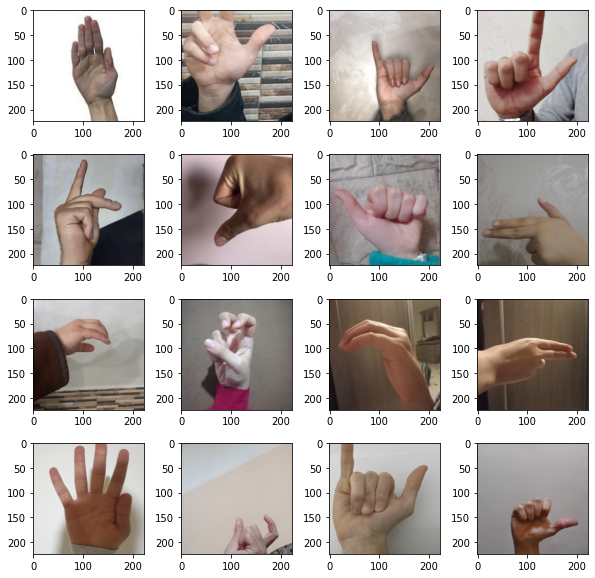

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].permute(1, 2, 0))
    # ax.axis('off')  # Turn off axis labels for each subplot

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()

### Add Tensorboard

In [37]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [38]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/{tensor_baord_variable}")

In [39]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image(
    f'images_{tensor_baord_variable}', img_grid)
writer.close()

In [40]:
%tensorboard --logdir="runs/{tensor_baord_variable}"

UsageError: Line magic function `%tensorboard` not found.


## Data visulization

In [41]:
from collections import Counter
import numpy as np

In [42]:
training_Targets = [] 
validation_Targets = [] 
testing_Targets = [] 

for i in X_train: 
  training_Targets.append(dataset.targets[i])

for i in X_validation: 
  validation_Targets.append(dataset.targets[i])

for i in X_test_after: 
  testing_Targets.append(dataset.targets[i])

In [43]:
C_training   = Counter(training_Targets) 
C_validation = Counter(validation_Targets)
C_testing    = Counter(testing_Targets)

In [44]:
dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

#### Training dataset

Text(0.5, 0, 'Label')

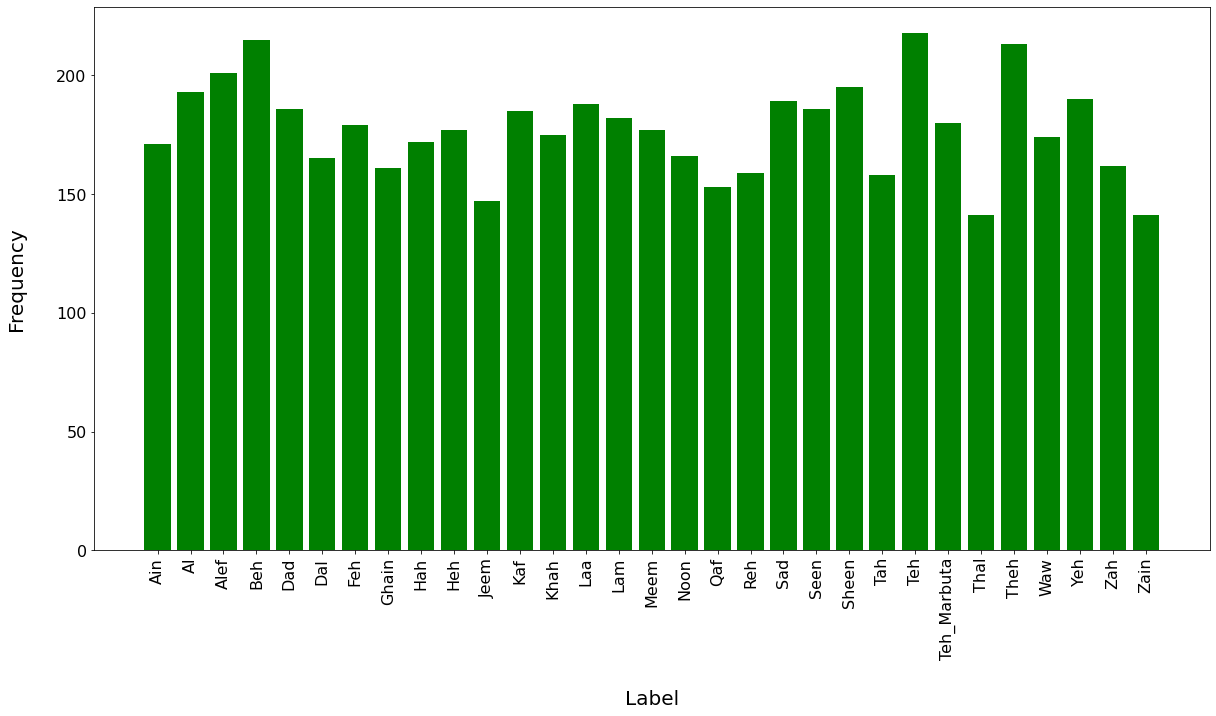

In [45]:
plt.figure(figsize=(20,10))
plt.bar(C_training.keys(), height=C_training.values(), color="green")

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);

plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Validation dataset

Text(0.5, 0, 'Label')

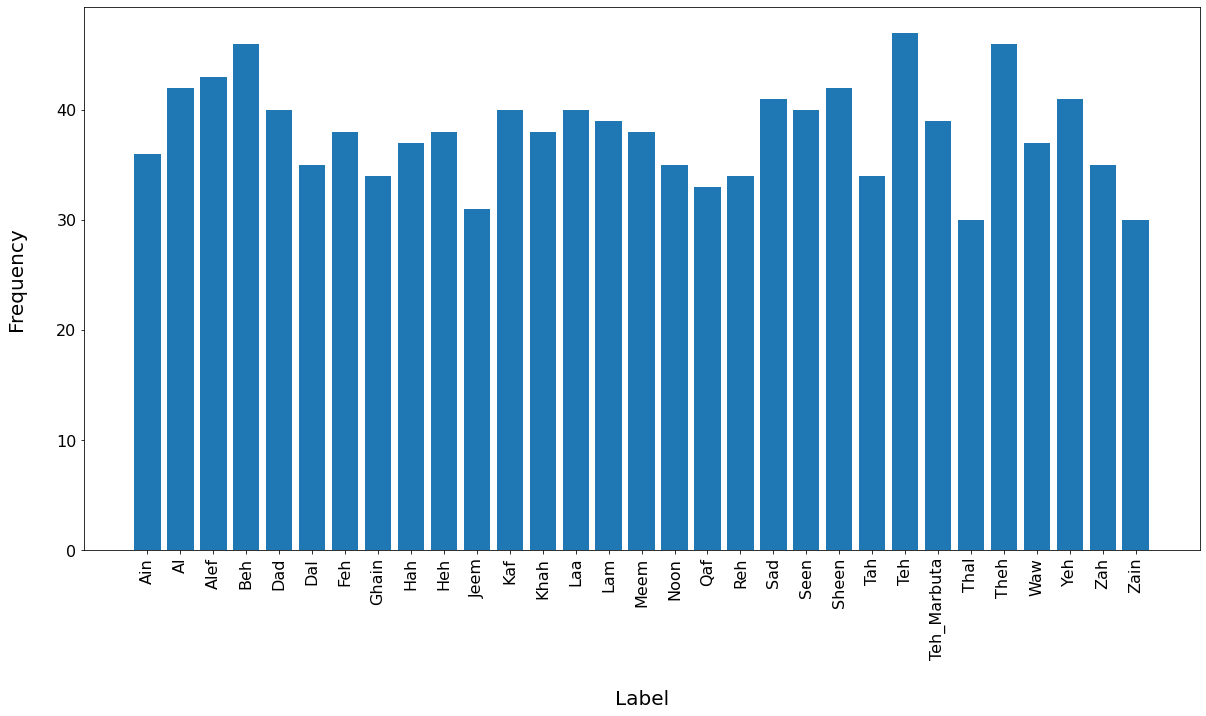

In [46]:
plt.figure(figsize=(20,10))
plt.bar(C_validation.keys(), height=C_validation.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Testing Dataset

Text(0.5, 0, 'Label')

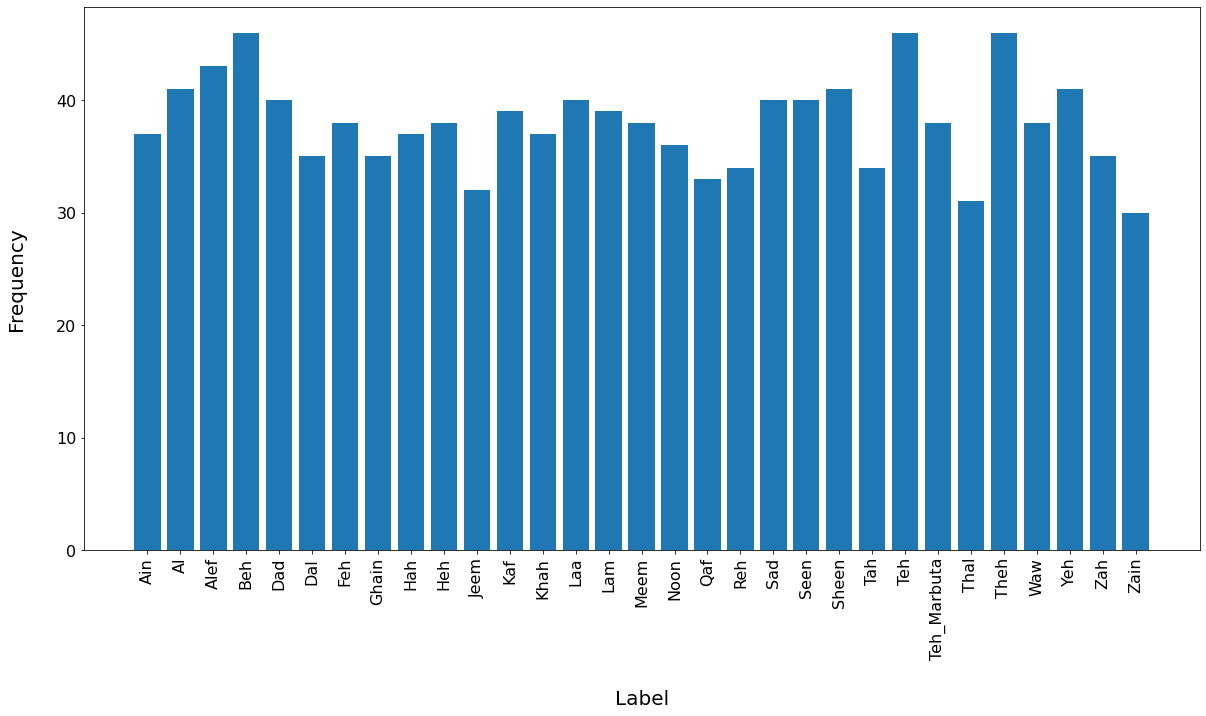

In [47]:
plt.figure(figsize=(20,10))

plt.bar(C_testing.keys(), height=C_testing.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

## Model Defenition

In [48]:
import torchvision.models as models
import torch.nn.functional as F

In [49]:
class Model(nn.Module):
    
    def __init__(self, in_channels=3, num_class =31):
        super(Model, self).__init__()

        # bring resnet
        self.model = models.resnet18(pretrained=True)
#         for param in self.model.parameters():
#             param.requires_grad = False
        num_ftrs = self.model.fc.in_features       
        self.model.fc = nn.Linear(num_ftrs, num_class)        

    def forward(self, x):
        return self.model(x)

model = Model()

In [50]:
# Move the model to the device
model.to(device)
model

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

### Check the gradient of layers of ResNet-18

In [51]:
for param in model.parameters():
    if not param.requires_grad:
        print("Freezing found on the layers")

## Define a Loss function and optimizer

In [52]:
# Define my Loss 

loss = nn.CrossEntropyLoss()

# Define my optimizer 

params = model.parameters()
optimzer = optim.SGD(params, lr=0.01)

optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Model Training & Validation

In [53]:
from tqdm import tqdm 

### Model training & Validation

In [54]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

In [55]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [56]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [57]:
All_end_eopch_training_loss = []
All_end_eopch_validation_loss = []

In [58]:
n_epochs = 300
accuracy, best_Acc = 0.0, 0.0, 
print_each_steps = 100
prev_avg_loss = float('inf')
 

# Batch calculations
n_total_steps = len(train_loader)
running_correct, running_loss_val, running_correct_val, training_running_loss = 0, 0.0, 0.0, 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    model.train()

    losses_training = [] 
    accuracies_tarining = []

    ###################
    # train the model #
    ###################  
    
    for i, batch in tqdm(enumerate(train_loader, 1),"Epoch # is {}".format(epoch) ,total = len(train_loader),position=0, leave=False):

        inputs, labels, _ = batch 

        # import pdb; pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 


        logits = logits.to(device)

        # Calculate loss
        J = loss(logits,labels)

        #  re-initlize gradiants, calculate gradients, update the weights
        optimzer.zero_grad(); J.backward() ; optimzer.step()

        # 
        training_running_loss += J.item()
        # _, predicted = torch.max(logits.data, 1)
        # running_correct += (predicted == labels).sum().item()


        losses_training.append(J.item())

        running_correct += labels.eq(logits.detach().argmax(dim=1)).float().mean()
        accuracies_tarining.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
    
        # Print some information each "print_each_steps" steps 

        if i%print_each_steps ==0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{n_total_steps}], Loss: {J.item():.8f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('Batch_training_loss', training_running_loss / print_each_steps, epoch * n_total_steps + i)
            running_accuracy = running_correct / print_each_steps  # 
            writer.add_scalar('Batch_training_accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            training_running_loss = 0.0
            ###################################################

    # End epoch calculations 
    End_Eopch_Training_Loss = torch.tensor(losses_training).float().mean()
    End_Eopch_Training_Acc  = torch.tensor(accuracies_tarining).float().mean()
  
    
    # Add training loss and training accuracy each epoch 
    writer.add_scalar('End_epoch_training_loss', End_Eopch_Training_Loss.item(),epoch)
    writer.add_scalar('End_epoch_training_accuracy', End_Eopch_Training_Acc.item(),epoch)


    print()
    print(f'Epoch {epoch + 1}/{n_epochs},  Step [{i}/{n_total_steps}]', end = ', ')
    print(f'Avg training loss: { End_Eopch_Training_Loss.item() : .8f}', end = ', ')
    print(f'Avg training accuracy : {End_Eopch_Training_Acc.item() : .8%}')
    print()


    
    
    ######################    
    # validate the model #
    ######################
        
    losses_validation = [] 
    accuracies_validation = []
  

    model.eval()
  
    with torch.no_grad():
        
        for batch in tqdm(val_loader, total = len(val_loader), position=0, leave=False):

            inputs, labels, _ = batch 

            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) # logits / scores 

            logits = logits.to(device)

            J = loss(logits,labels)


            losses_validation.append(J.item())

            running_loss_val += J.item()
            losses_validation.append(J.item())


            running_correct = labels.eq(logits.detach().argmax(dim=1)).float().mean()
            accuracies_validation.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
      
        current_loss  = torch.tensor(losses_validation).float().mean()
        current_Accuracy = torch.tensor(accuracies_validation).float().mean()
                  

        writer.add_scalar('End epoch, Validation loss', running_loss_val / len(val_loader), epoch)
        running_accuracy = running_correct / len(val_loader) 
        writer.add_scalar('End epoch, Validation accuracy', running_accuracy, epoch )
        

        print()  
        print(f'Epoch {epoch + 1}', end = ', ')
        print(f'Avg validation loss: {current_loss :.8f}', end = ', ')
        print(f'Avg validation accuracy : {current_Accuracy :.8%}')
        print()



        if current_loss < prev_avg_loss:

            prev_avg_loss = current_loss

            print()
            print('The best validation Loss is ', prev_avg_loss.item())
            print('The Current Accuracy of validation is ', current_Accuracy.item() * 100)
            print()

            torch.save(model.state_dict(), path)
      
        if current_Accuracy > best_Acc :

            best_Acc = current_Accuracy

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(current_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
        # Add training loss and training accuracy each epoch 
        writer.add_scalar('End_epoch_validation_loss', torch.tensor(losses_validation).float().mean().item(),epoch)
        writer.add_scalar('End_epoch_validation_accuracy', torch.tensor(accuracies_validation).float().mean().item(),epoch)

    # End epoch, training dataset
    All_end_eopch_validation_loss.append(torch.tensor(losses_validation).float().mean().item())
    
    # End epoch, training dataset
    All_end_eopch_training_loss.append(End_Eopch_Training_Loss.item())  
    
    writer.add_scalars('Traning_Validation', {'EOP_training loss':End_Eopch_Training_Loss.item(),
                                            'EOP_Validation loss':torch.tensor(losses_validation).float().mean().item()},
                                             epoch)

    running_loss_val = 0.0 
    running_correct_val = 0
    


Epoch 1/300,  Step [86/86], Avg training loss:  2.67162561, Avg training accuracy :  32.49070048%




Epoch 1, Avg validation loss: 1.68795133, Avg validation accuracy : 64.31225538%


The best validation Loss is  1.6879513263702393
The Current Accuracy of validation is  64.31225538253784

Validation loss decreased (inf --> 1.687951).  Saving model ...



Epoch 2/300,  Step [86/86], Avg training loss:  1.22839510, Avg training accuracy :  78.81971598%




Epoch 2, Avg validation loss: 0.89669085, Avg validation accuracy : 84.94152427%


The best validation Loss is  0.896690845489502
The Current Accuracy of validation is  84.94152426719666

Validation loss decreased (1.687951 --> 0.896691).  Saving model ...



Epoch 3/300,  Step [86/86], Avg training loss:  0.65952313, Avg training accuracy :  90.54154754%




Epoch 3, Avg validation loss: 0.57777995, Avg validation accuracy : 90.39961100%


The best validation Loss is  0.5777799487113953
The Current Accuracy of validation is  90.39961099624634

Validation loss decreased (0.896691 --> 0.577780).  Saving model ...



Epoch 4/300,  Step [86/86], Avg training loss:  0.41589275, Avg training accuracy :  94.45087314%




Epoch 4, Avg validation loss: 0.41798797, Avg validation accuracy : 92.94895530%


The best validation Loss is  0.41798797249794006
The Current Accuracy of validation is  92.94895529747009

Validation loss decreased (0.577780 --> 0.417988).  Saving model ...



Epoch 5/300,  Step [86/86], Avg training loss:  0.28775036, Avg training accuracy :  96.61293626%




Epoch 5, Avg validation loss: 0.33580565, Avg validation accuracy : 93.68908405%


The best validation Loss is  0.33580565452575684
The Current Accuracy of validation is  93.68908405303955

Validation loss decreased (0.417988 --> 0.335806).  Saving model ...



Epoch 6/300,  Step [86/86], Avg training loss:  0.20954835, Avg training accuracy :  97.70613313%




Epoch 6, Avg validation loss: 0.28391540, Avg validation accuracy : 94.13072467%


The best validation Loss is  0.2839154005050659
The Current Accuracy of validation is  94.13072466850281

Validation loss decreased (0.335806 --> 0.283915).  Saving model ...



Epoch 7/300,  Step [86/86], Avg training loss:  0.15789488, Avg training accuracy :  98.56160283%




Epoch 7, Avg validation loss: 0.25086650, Avg validation accuracy : 94.29519773%


The best validation Loss is  0.25086650252342224
The Current Accuracy of validation is  94.29519772529602

Validation loss decreased (0.283915 --> 0.250867).  Saving model ...



Epoch 8/300,  Step [86/86], Avg training loss:  0.12223112, Avg training accuracy :  99.10819530%




Epoch 8, Avg validation loss: 0.22791012, Avg validation accuracy : 95.03533244%


The best validation Loss is  0.227910116314888
The Current Accuracy of validation is  95.03533244132996

Validation loss decreased (0.250867 --> 0.227910).  Saving model ...



Epoch 9/300,  Step [86/86], Avg training loss:  0.09684858, Avg training accuracy :  99.48973656%




Epoch 9, Avg validation loss: 0.21083780, Avg validation accuracy : 95.11756897%


The best validation Loss is  0.21083779633045197
The Current Accuracy of validation is  95.11756896972656

Validation loss decreased (0.227910 --> 0.210838).  Saving model ...



Epoch 10/300,  Step [86/86], Avg training loss:  0.07842605, Avg training accuracy :  99.67296720%




Epoch 10, Avg validation loss: 0.19741847, Avg validation accuracy : 95.36427855%


The best validation Loss is  0.1974184662103653
The Current Accuracy of validation is  95.36427855491638

Validation loss decreased (0.210838 --> 0.197418).  Saving model ...



Epoch 11/300,  Step [86/86], Avg training loss:  0.06477604, Avg training accuracy :  99.81831312%




Epoch 11, Avg validation loss: 0.18659814, Avg validation accuracy : 95.64144611%


The best validation Loss is  0.18659813702106476
The Current Accuracy of validation is  95.64144611358643

Validation loss decreased (0.197418 --> 0.186598).  Saving model ...



Epoch 12/300,  Step [86/86], Avg training loss:  0.05447891, Avg training accuracy :  99.87282157%




Epoch 12, Avg validation loss: 0.17835419, Avg validation accuracy : 96.05262876%


The best validation Loss is  0.1783541887998581
The Current Accuracy of validation is  96.05262875556946

Validation loss decreased (0.186598 --> 0.178354).  Saving model ...



Epoch 13/300,  Step [86/86], Avg training loss:  0.04657101, Avg training accuracy :  99.90915656%




Epoch 13, Avg validation loss: 0.17085427, Avg validation accuracy : 96.13487124%


The best validation Loss is  0.17085427045822144
The Current Accuracy of validation is  96.13487124443054

Validation loss decreased (0.178354 --> 0.170854).  Saving model ...



Epoch 14/300,  Step [86/86], Avg training loss:  0.04038610, Avg training accuracy :  99.90915656%




Epoch 14, Avg validation loss: 0.16490276, Avg validation accuracy : 96.21710777%


The best validation Loss is  0.16490276157855988
The Current Accuracy of validation is  96.21710777282715

Validation loss decreased (0.170854 --> 0.164903).  Saving model ...



Epoch 15/300,  Step [86/86], Avg training loss:  0.03547068, Avg training accuracy :  99.92732406%




Epoch 15, Avg validation loss: 0.16010374, Avg validation accuracy : 96.29934430%


The best validation Loss is  0.16010373830795288
The Current Accuracy of validation is  96.29934430122375

Validation loss decreased (0.164903 --> 0.160104).  Saving model ...



Epoch 16/300,  Step [86/86], Avg training loss:  0.03150315, Avg training accuracy :  99.94549155%




Epoch 16, Avg validation loss: 0.15596822, Avg validation accuracy : 96.38158083%


The best validation Loss is  0.15596821904182434
The Current Accuracy of validation is  96.38158082962036

Validation loss decreased (0.160104 --> 0.155968).  Saving model ...



Epoch 17/300,  Step [86/86], Avg training loss:  0.02825500, Avg training accuracy :  99.96366501%




Epoch 17, Avg validation loss: 0.15238874, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.15238873660564423
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.155968 --> 0.152389).  Saving model ...



Epoch 18/300,  Step [86/86], Avg training loss:  0.02555451, Avg training accuracy :  99.96366501%




Epoch 18, Avg validation loss: 0.14929076, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1492907553911209
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.152389 --> 0.149291).  Saving model ...



Epoch 19/300,  Step [86/86], Avg training loss:  0.02328019, Avg training accuracy :  99.96366501%




Epoch 19, Avg validation loss: 0.14679715, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.14679715037345886
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.149291 --> 0.146797).  Saving model ...



Epoch 20/300,  Step [86/86], Avg training loss:  0.02134816, Avg training accuracy :  99.96366501%




Epoch 20, Avg validation loss: 0.14455366, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.14455366134643555
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.146797 --> 0.144554).  Saving model ...



Epoch 21/300,  Step [86/86], Avg training loss:  0.01968740, Avg training accuracy :  99.96366501%




Epoch 21, Avg validation loss: 0.14262743, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.14262743294239044
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.144554 --> 0.142627).  Saving model ...



Epoch 22/300,  Step [86/86], Avg training loss:  0.01825120, Avg training accuracy :  99.96366501%




Epoch 22, Avg validation loss: 0.14087784, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1408778429031372
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.142627 --> 0.140878).  Saving model ...



Epoch 23/300,  Step [86/86], Avg training loss:  0.01699299, Avg training accuracy :  99.96366501%




Epoch 23, Avg validation loss: 0.13927895, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.13927894830703735
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.140878 --> 0.139279).  Saving model ...



Epoch 24/300,  Step [86/86], Avg training loss:  0.01588518, Avg training accuracy :  99.96366501%




Epoch 24, Avg validation loss: 0.13789296, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1378929615020752
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.139279 --> 0.137893).  Saving model ...



Epoch 25/300,  Step [86/86], Avg training loss:  0.01490272, Avg training accuracy :  99.96366501%




Epoch 25, Avg validation loss: 0.13666728, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.13666728138923645
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.137893 --> 0.136667).  Saving model ...



Epoch 26/300,  Step [86/86], Avg training loss:  0.01402700, Avg training accuracy :  99.96366501%




Epoch 26, Avg validation loss: 0.13553259, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.13553258776664734
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.136667 --> 0.135533).  Saving model ...



Epoch 27/300,  Step [86/86], Avg training loss:  0.01324054, Avg training accuracy :  99.96366501%




Epoch 27, Avg validation loss: 0.13456558, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1345655769109726
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.135533 --> 0.134566).  Saving model ...



Epoch 28/300,  Step [86/86], Avg training loss:  0.01252919, Avg training accuracy :  99.98183250%




Epoch 28, Avg validation loss: 0.13363105, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.13363105058670044
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.134566 --> 0.133631).  Saving model ...



Epoch 29/300,  Step [86/86], Avg training loss:  0.01188293, Avg training accuracy :  99.98183250%




Epoch 29, Avg validation loss: 0.13276164, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1327616423368454
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.133631 --> 0.132762).  Saving model ...



Epoch 30/300,  Step [86/86], Avg training loss:  0.01129753, Avg training accuracy :  99.98183250%




Epoch 30, Avg validation loss: 0.13198839, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.13198839128017426
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.132762 --> 0.131988).  Saving model ...



Epoch 31/300,  Step [86/86], Avg training loss:  0.01075731, Avg training accuracy :  99.98183250%




Epoch 31, Avg validation loss: 0.13126916, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1312691569328308
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.131988 --> 0.131269).  Saving model ...



Epoch 32/300,  Step [86/86], Avg training loss:  0.01026168, Avg training accuracy :  99.98183250%




Epoch 32, Avg validation loss: 0.13063988, Avg validation accuracy : 96.38158083%


The best validation Loss is  0.13063988089561462
The Current Accuracy of validation is  96.38158082962036

Validation loss decreased (0.131269 --> 0.130640).  Saving model ...



Epoch 33/300,  Step [86/86], Avg training loss:  0.00980054, Avg training accuracy :  99.98183250%




Epoch 33, Avg validation loss: 0.13002717, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.130027174949646
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.130640 --> 0.130027).  Saving model ...



Epoch 34/300,  Step [86/86], Avg training loss:  0.00937323, Avg training accuracy :  99.98183250%




Epoch 34, Avg validation loss: 0.12948218, Avg validation accuracy : 96.38158083%


The best validation Loss is  0.1294821798801422
The Current Accuracy of validation is  96.38158082962036

Validation loss decreased (0.130027 --> 0.129482).  Saving model ...



Epoch 35/300,  Step [86/86], Avg training loss:  0.00896838, Avg training accuracy :  99.98183250%




Epoch 35, Avg validation loss: 0.12893012, Avg validation accuracy : 96.38158083%


The best validation Loss is  0.12893012166023254
The Current Accuracy of validation is  96.38158082962036

Validation loss decreased (0.129482 --> 0.128930).  Saving model ...



Epoch 36/300,  Step [86/86], Avg training loss:  0.00857981, Avg training accuracy :  99.98183250%




Epoch 36, Avg validation loss: 0.12844446, Avg validation accuracy : 96.38158083%


The best validation Loss is  0.12844446301460266
The Current Accuracy of validation is  96.38158082962036

Validation loss decreased (0.128930 --> 0.128444).  Saving model ...



Epoch 37/300,  Step [86/86], Avg training loss:  0.00819599, Avg training accuracy :  99.98183250%




Epoch 37, Avg validation loss: 0.12798046, Avg validation accuracy : 96.38158083%


The best validation Loss is  0.12798045575618744
The Current Accuracy of validation is  96.38158082962036

Validation loss decreased (0.128444 --> 0.127980).  Saving model ...



Epoch 38/300,  Step [86/86], Avg training loss:  0.00782475, Avg training accuracy :  100.00000000%




Epoch 38, Avg validation loss: 0.12749819, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12749819457530975
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.127980 --> 0.127498).  Saving model ...



Epoch 39/300,  Step [86/86], Avg training loss:  0.00746883, Avg training accuracy :  100.00000000%




Epoch 39, Avg validation loss: 0.12705985, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12705984711647034
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.127498 --> 0.127060).  Saving model ...



Epoch 40/300,  Step [86/86], Avg training loss:  0.00714729, Avg training accuracy :  100.00000000%




Epoch 40, Avg validation loss: 0.12673211, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12673211097717285
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.127060 --> 0.126732).  Saving model ...



Epoch 41/300,  Step [86/86], Avg training loss:  0.00686305, Avg training accuracy :  100.00000000%




Epoch 41, Avg validation loss: 0.12638725, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12638725340366364
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.126732 --> 0.126387).  Saving model ...



Epoch 42/300,  Step [86/86], Avg training loss:  0.00661298, Avg training accuracy :  100.00000000%




Epoch 42, Avg validation loss: 0.12608700, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.1260869950056076
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.126387 --> 0.126087).  Saving model ...



Epoch 43/300,  Step [86/86], Avg training loss:  0.00638347, Avg training accuracy :  100.00000000%




Epoch 43, Avg validation loss: 0.12576355, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12576355040073395
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.126087 --> 0.125764).  Saving model ...



Epoch 44/300,  Step [86/86], Avg training loss:  0.00617108, Avg training accuracy :  100.00000000%




Epoch 44, Avg validation loss: 0.12548254, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12548254430294037
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.125764 --> 0.125483).  Saving model ...



Epoch 45/300,  Step [86/86], Avg training loss:  0.00597224, Avg training accuracy :  100.00000000%




Epoch 45, Avg validation loss: 0.12521617, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.12521617114543915
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.125483 --> 0.125216).  Saving model ...



Epoch 46/300,  Step [86/86], Avg training loss:  0.00578672, Avg training accuracy :  100.00000000%




Epoch 46, Avg validation loss: 0.12497675, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.124976746737957
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.125216 --> 0.124977).  Saving model ...



Epoch 47/300,  Step [86/86], Avg training loss:  0.00561216, Avg training accuracy :  100.00000000%




Epoch 47, Avg validation loss: 0.12471614, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1247161403298378
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.124977 --> 0.124716).  Saving model ...



Epoch 48/300,  Step [86/86], Avg training loss:  0.00544554, Avg training accuracy :  100.00000000%




Epoch 48, Avg validation loss: 0.12449720, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1244971975684166
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.124716 --> 0.124497).  Saving model ...



Epoch 49/300,  Step [86/86], Avg training loss:  0.00528989, Avg training accuracy :  100.00000000%




Epoch 49, Avg validation loss: 0.12428186, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1242818608880043
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.124497 --> 0.124282).  Saving model ...



Epoch 50/300,  Step [86/86], Avg training loss:  0.00514117, Avg training accuracy :  100.00000000%




Epoch 50, Avg validation loss: 0.12408961, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12408960610628128
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.124282 --> 0.124090).  Saving model ...



Epoch 51/300,  Step [86/86], Avg training loss:  0.00500157, Avg training accuracy :  100.00000000%




Epoch 51, Avg validation loss: 0.12389060, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12389060109853745
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.124090 --> 0.123891).  Saving model ...



Epoch 52/300,  Step [86/86], Avg training loss:  0.00486669, Avg training accuracy :  100.00000000%




Epoch 52, Avg validation loss: 0.12371014, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12371014058589935
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.123891 --> 0.123710).  Saving model ...



Epoch 53/300,  Step [86/86], Avg training loss:  0.00474047, Avg training accuracy :  100.00000000%




Epoch 53, Avg validation loss: 0.12352839, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.123528391122818
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.123710 --> 0.123528).  Saving model ...



Epoch 54/300,  Step [86/86], Avg training loss:  0.00461785, Avg training accuracy :  100.00000000%




Epoch 54, Avg validation loss: 0.12336439, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1233643889427185
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.123528 --> 0.123364).  Saving model ...



Epoch 55/300,  Step [86/86], Avg training loss:  0.00450354, Avg training accuracy :  100.00000000%




Epoch 55, Avg validation loss: 0.12318556, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12318556010723114
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.123364 --> 0.123186).  Saving model ...



Epoch 56/300,  Step [86/86], Avg training loss:  0.00439275, Avg training accuracy :  100.00000000%




Epoch 56, Avg validation loss: 0.12303682, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12303682416677475
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.123186 --> 0.123037).  Saving model ...



Epoch 57/300,  Step [86/86], Avg training loss:  0.00428722, Avg training accuracy :  100.00000000%




Epoch 57, Avg validation loss: 0.12288277, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12288276851177216
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.123037 --> 0.122883).  Saving model ...



Epoch 58/300,  Step [86/86], Avg training loss:  0.00418625, Avg training accuracy :  100.00000000%




Epoch 58, Avg validation loss: 0.12274713, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12274713069200516
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122883 --> 0.122747).  Saving model ...



Epoch 59/300,  Step [86/86], Avg training loss:  0.00408942, Avg training accuracy :  100.00000000%




Epoch 59, Avg validation loss: 0.12259802, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12259802222251892
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122747 --> 0.122598).  Saving model ...



Epoch 60/300,  Step [86/86], Avg training loss:  0.00399764, Avg training accuracy :  100.00000000%




Epoch 60, Avg validation loss: 0.12246185, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12246184796094894
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122598 --> 0.122462).  Saving model ...



Epoch 61/300,  Step [86/86], Avg training loss:  0.00390785, Avg training accuracy :  100.00000000%




Epoch 61, Avg validation loss: 0.12232707, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12232707440853119
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122462 --> 0.122327).  Saving model ...



Epoch 62/300,  Step [86/86], Avg training loss:  0.00382340, Avg training accuracy :  100.00000000%




Epoch 62, Avg validation loss: 0.12220807, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12220806628465652
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122327 --> 0.122208).  Saving model ...



Epoch 63/300,  Step [86/86], Avg training loss:  0.00374070, Avg training accuracy :  100.00000000%




Epoch 63, Avg validation loss: 0.12208463, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12208463251590729
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122208 --> 0.122085).  Saving model ...



Epoch 64/300,  Step [86/86], Avg training loss:  0.00366302, Avg training accuracy :  100.00000000%




Epoch 64, Avg validation loss: 0.12197984, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12197984009981155
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.122085 --> 0.121980).  Saving model ...



Epoch 65/300,  Step [86/86], Avg training loss:  0.00358598, Avg training accuracy :  100.00000000%




Epoch 65, Avg validation loss: 0.12186718, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12186717987060547
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121980 --> 0.121867).  Saving model ...



Epoch 66/300,  Step [86/86], Avg training loss:  0.00351478, Avg training accuracy :  100.00000000%




Epoch 66, Avg validation loss: 0.12176869, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12176869064569473
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121867 --> 0.121769).  Saving model ...



Epoch 67/300,  Step [86/86], Avg training loss:  0.00344341, Avg training accuracy :  100.00000000%




Epoch 67, Avg validation loss: 0.12167782, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12167782336473465
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121769 --> 0.121678).  Saving model ...



Epoch 68/300,  Step [86/86], Avg training loss:  0.00337591, Avg training accuracy :  100.00000000%




Epoch 68, Avg validation loss: 0.12158273, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12158273160457611
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121678 --> 0.121583).  Saving model ...



Epoch 69/300,  Step [86/86], Avg training loss:  0.00331039, Avg training accuracy :  100.00000000%




Epoch 69, Avg validation loss: 0.12148148, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12148147821426392
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121583 --> 0.121481).  Saving model ...



Epoch 70/300,  Step [86/86], Avg training loss:  0.00324786, Avg training accuracy :  100.00000000%




Epoch 70, Avg validation loss: 0.12140560, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12140560150146484
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121481 --> 0.121406).  Saving model ...



Epoch 71/300,  Step [86/86], Avg training loss:  0.00318653, Avg training accuracy :  100.00000000%




Epoch 71, Avg validation loss: 0.12132050, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12132050096988678
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121406 --> 0.121321).  Saving model ...



Epoch 72/300,  Step [86/86], Avg training loss:  0.00312836, Avg training accuracy :  100.00000000%




Epoch 72, Avg validation loss: 0.12125153, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12125153094530106
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121321 --> 0.121252).  Saving model ...



Epoch 73/300,  Step [86/86], Avg training loss:  0.00307092, Avg training accuracy :  100.00000000%




Epoch 73, Avg validation loss: 0.12116654, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12116654217243195
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121252 --> 0.121167).  Saving model ...



Epoch 74/300,  Step [86/86], Avg training loss:  0.00301652, Avg training accuracy :  100.00000000%




Epoch 74, Avg validation loss: 0.12109957, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1210995689034462
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121167 --> 0.121100).  Saving model ...



Epoch 75/300,  Step [86/86], Avg training loss:  0.00296322, Avg training accuracy :  100.00000000%




Epoch 75, Avg validation loss: 0.12102324, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12102323770523071
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121100 --> 0.121023).  Saving model ...



Epoch 76/300,  Step [86/86], Avg training loss:  0.00291213, Avg training accuracy :  100.00000000%




Epoch 76, Avg validation loss: 0.12095527, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12095526605844498
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.121023 --> 0.120955).  Saving model ...



Epoch 77/300,  Step [86/86], Avg training loss:  0.00286207, Avg training accuracy :  100.00000000%




Epoch 77, Avg validation loss: 0.12088620, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12088619917631149
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120955 --> 0.120886).  Saving model ...



Epoch 78/300,  Step [86/86], Avg training loss:  0.00281395, Avg training accuracy :  100.00000000%




Epoch 78, Avg validation loss: 0.12083272, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12083271890878677
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120886 --> 0.120833).  Saving model ...



Epoch 79/300,  Step [86/86], Avg training loss:  0.00276690, Avg training accuracy :  100.00000000%




Epoch 79, Avg validation loss: 0.12076750, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1207675039768219
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120833 --> 0.120768).  Saving model ...



Epoch 80/300,  Step [86/86], Avg training loss:  0.00272208, Avg training accuracy :  100.00000000%




Epoch 80, Avg validation loss: 0.12071636, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12071635574102402
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120768 --> 0.120716).  Saving model ...



Epoch 81/300,  Step [86/86], Avg training loss:  0.00267755, Avg training accuracy :  100.00000000%




Epoch 81, Avg validation loss: 0.12065580, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12065579742193222
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120716 --> 0.120656).  Saving model ...



Epoch 82/300,  Step [86/86], Avg training loss:  0.00263532, Avg training accuracy :  100.00000000%




Epoch 82, Avg validation loss: 0.12061179, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12061179429292679
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120656 --> 0.120612).  Saving model ...



Epoch 83/300,  Step [86/86], Avg training loss:  0.00259346, Avg training accuracy :  100.00000000%




Epoch 83, Avg validation loss: 0.12055635, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12055635452270508
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120612 --> 0.120556).  Saving model ...



Epoch 84/300,  Step [86/86], Avg training loss:  0.00255374, Avg training accuracy :  100.00000000%




Epoch 84, Avg validation loss: 0.12050333, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12050332874059677
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120556 --> 0.120503).  Saving model ...



Epoch 85/300,  Step [86/86], Avg training loss:  0.00251404, Avg training accuracy :  100.00000000%




Epoch 85, Avg validation loss: 0.12045303, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12045302987098694
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120503 --> 0.120453).  Saving model ...



Epoch 86/300,  Step [86/86], Avg training loss:  0.00247682, Avg training accuracy :  100.00000000%




Epoch 86, Avg validation loss: 0.12041086, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12041085958480835
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120453 --> 0.120411).  Saving model ...



Epoch 87/300,  Step [86/86], Avg training loss:  0.00243925, Avg training accuracy :  100.00000000%




Epoch 87, Avg validation loss: 0.12036064, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12036063522100449
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120411 --> 0.120361).  Saving model ...



Epoch 88/300,  Step [86/86], Avg training loss:  0.00240389, Avg training accuracy :  100.00000000%




Epoch 88, Avg validation loss: 0.12031982, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12031982094049454
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120361 --> 0.120320).  Saving model ...



Epoch 89/300,  Step [86/86], Avg training loss:  0.00236828, Avg training accuracy :  100.00000000%




Epoch 89, Avg validation loss: 0.12028305, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12028305232524872
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120320 --> 0.120283).  Saving model ...



Epoch 90/300,  Step [86/86], Avg training loss:  0.00233509, Avg training accuracy :  100.00000000%




Epoch 90, Avg validation loss: 0.12024269, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12024268507957458
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120283 --> 0.120243).  Saving model ...



Epoch 91/300,  Step [86/86], Avg training loss:  0.00230141, Avg training accuracy :  100.00000000%




Epoch 91, Avg validation loss: 0.12020854, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12020853906869888
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120243 --> 0.120209).  Saving model ...



Epoch 92/300,  Step [86/86], Avg training loss:  0.00226940, Avg training accuracy :  100.00000000%




Epoch 92, Avg validation loss: 0.12016755, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12016754597425461
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120209 --> 0.120168).  Saving model ...



Epoch 93/300,  Step [86/86], Avg training loss:  0.00223779, Avg training accuracy :  100.00000000%




Epoch 93, Avg validation loss: 0.12012430, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12012430280447006
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120168 --> 0.120124).  Saving model ...



Epoch 94/300,  Step [86/86], Avg training loss:  0.00220728, Avg training accuracy :  100.00000000%




Epoch 94, Avg validation loss: 0.12008780, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12008780241012573
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120124 --> 0.120088).  Saving model ...



Epoch 95/300,  Step [86/86], Avg training loss:  0.00217720, Avg training accuracy :  100.00000000%




Epoch 95, Avg validation loss: 0.12005071, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12005070596933365
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120088 --> 0.120051).  Saving model ...



Epoch 96/300,  Step [86/86], Avg training loss:  0.00214845, Avg training accuracy :  100.00000000%




Epoch 96, Avg validation loss: 0.12001996, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.12001996487379074
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120051 --> 0.120020).  Saving model ...



Epoch 97/300,  Step [86/86], Avg training loss:  0.00211972, Avg training accuracy :  100.00000000%




Epoch 97, Avg validation loss: 0.11998787, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1199878677725792
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.120020 --> 0.119988).  Saving model ...



Epoch 98/300,  Step [86/86], Avg training loss:  0.00209236, Avg training accuracy :  100.00000000%




Epoch 98, Avg validation loss: 0.11995600, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11995600163936615
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119988 --> 0.119956).  Saving model ...



Epoch 99/300,  Step [86/86], Avg training loss:  0.00206503, Avg training accuracy :  100.00000000%




Epoch 99, Avg validation loss: 0.11993137, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11993137001991272
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119956 --> 0.119931).  Saving model ...



Epoch 100/300,  Step [86/86], Avg training loss:  0.00203880, Avg training accuracy :  100.00000000%




Epoch 100, Avg validation loss: 0.11989810, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11989810317754745
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119931 --> 0.119898).  Saving model ...



Epoch 101/300,  Step [86/86], Avg training loss:  0.00201292, Avg training accuracy :  100.00000000%




Epoch 101, Avg validation loss: 0.11987224, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11987224221229553
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119898 --> 0.119872).  Saving model ...



Epoch 102/300,  Step [86/86], Avg training loss:  0.00198793, Avg training accuracy :  100.00000000%




Epoch 102, Avg validation loss: 0.11984579, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11984579265117645
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119872 --> 0.119846).  Saving model ...



Epoch 103/300,  Step [86/86], Avg training loss:  0.00196305, Avg training accuracy :  100.00000000%




Epoch 103, Avg validation loss: 0.11982018, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11982017755508423
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119846 --> 0.119820).  Saving model ...



Epoch 104/300,  Step [86/86], Avg training loss:  0.00193923, Avg training accuracy :  100.00000000%




Epoch 104, Avg validation loss: 0.11979570, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11979570239782333
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119820 --> 0.119796).  Saving model ...



Epoch 105/300,  Step [86/86], Avg training loss:  0.00191568, Avg training accuracy :  100.00000000%




Epoch 105, Avg validation loss: 0.11976011, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11976011097431183
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119796 --> 0.119760).  Saving model ...



Epoch 106/300,  Step [86/86], Avg training loss:  0.00189272, Avg training accuracy :  100.00000000%




Epoch 106, Avg validation loss: 0.11974415, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11974415183067322
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119760 --> 0.119744).  Saving model ...



Epoch 107/300,  Step [86/86], Avg training loss:  0.00187021, Avg training accuracy :  100.00000000%




Epoch 107, Avg validation loss: 0.11972000, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.11972000449895859
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.119744 --> 0.119720).  Saving model ...



Epoch 108/300,  Step [86/86], Avg training loss:  0.00184824, Avg training accuracy :  100.00000000%




Epoch 108, Avg validation loss: 0.11969890, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.1196989044547081
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.119720 --> 0.119699).  Saving model ...



Epoch 109/300,  Step [86/86], Avg training loss:  0.00182664, Avg training accuracy :  100.00000000%




Epoch 109, Avg validation loss: 0.11967053, Avg validation accuracy : 96.46381736%


The best validation Loss is  0.11967053264379501
The Current Accuracy of validation is  96.46381735801697

Validation loss decreased (0.119699 --> 0.119671).  Saving model ...



Epoch 110/300,  Step [86/86], Avg training loss:  0.00180598, Avg training accuracy :  100.00000000%




Epoch 110, Avg validation loss: 0.11965467, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11965467035770416
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119671 --> 0.119655).  Saving model ...



Epoch 111/300,  Step [86/86], Avg training loss:  0.00178500, Avg training accuracy :  100.00000000%




Epoch 111, Avg validation loss: 0.11962867, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1196286678314209
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119655 --> 0.119629).  Saving model ...



Epoch 112/300,  Step [86/86], Avg training loss:  0.00176514, Avg training accuracy :  100.00000000%




Epoch 112, Avg validation loss: 0.11960664, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11960664391517639
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119629 --> 0.119607).  Saving model ...



Epoch 113/300,  Step [86/86], Avg training loss:  0.00174520, Avg training accuracy :  100.00000000%




Epoch 113, Avg validation loss: 0.11958525, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11958525329828262
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119607 --> 0.119585).  Saving model ...



Epoch 114/300,  Step [86/86], Avg training loss:  0.00172602, Avg training accuracy :  100.00000000%




Epoch 114, Avg validation loss: 0.11956321, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11956321448087692
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119585 --> 0.119563).  Saving model ...



Epoch 115/300,  Step [86/86], Avg training loss:  0.00170697, Avg training accuracy :  100.00000000%




Epoch 115, Avg validation loss: 0.11954560, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1195456013083458
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119563 --> 0.119546).  Saving model ...



Epoch 116/300,  Step [86/86], Avg training loss:  0.00168852, Avg training accuracy :  100.00000000%




Epoch 116, Avg validation loss: 0.11952872, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11952871829271317
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119546 --> 0.119529).  Saving model ...



Epoch 117/300,  Step [86/86], Avg training loss:  0.00167020, Avg training accuracy :  100.00000000%




Epoch 117, Avg validation loss: 0.11950707, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1195070743560791
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119529 --> 0.119507).  Saving model ...



Epoch 118/300,  Step [86/86], Avg training loss:  0.00165267, Avg training accuracy :  100.00000000%




Epoch 118, Avg validation loss: 0.11949217, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11949216574430466
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119507 --> 0.119492).  Saving model ...



Epoch 119/300,  Step [86/86], Avg training loss:  0.00163494, Avg training accuracy :  100.00000000%




Epoch 119, Avg validation loss: 0.11946578, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11946577578783035
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119492 --> 0.119466).  Saving model ...



Epoch 120/300,  Step [86/86], Avg training loss:  0.00161809, Avg training accuracy :  100.00000000%




Epoch 120, Avg validation loss: 0.11945329, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11945328861474991
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119466 --> 0.119453).  Saving model ...



Epoch 121/300,  Step [86/86], Avg training loss:  0.00160103, Avg training accuracy :  100.00000000%




Epoch 121, Avg validation loss: 0.11943531, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11943531036376953
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119453 --> 0.119435).  Saving model ...



Epoch 122/300,  Step [86/86], Avg training loss:  0.00158480, Avg training accuracy :  100.00000000%




Epoch 122, Avg validation loss: 0.11941816, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11941815912723541
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119435 --> 0.119418).  Saving model ...



Epoch 123/300,  Step [86/86], Avg training loss:  0.00156850, Avg training accuracy :  100.00000000%




Epoch 123, Avg validation loss: 0.11939853, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11939853429794312
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119418 --> 0.119399).  Saving model ...



Epoch 124/300,  Step [86/86], Avg training loss:  0.00155275, Avg training accuracy :  100.00000000%




Epoch 124, Avg validation loss: 0.11939017, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11939017474651337
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119399 --> 0.119390).  Saving model ...



Epoch 125/300,  Step [86/86], Avg training loss:  0.00153696, Avg training accuracy :  100.00000000%




Epoch 125, Avg validation loss: 0.11936810, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11936809867620468
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119390 --> 0.119368).  Saving model ...



Epoch 126/300,  Step [86/86], Avg training loss:  0.00152207, Avg training accuracy :  100.00000000%




Epoch 126, Avg validation loss: 0.11935848, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11935847997665405
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119368 --> 0.119358).  Saving model ...



Epoch 127/300,  Step [86/86], Avg training loss:  0.00150677, Avg training accuracy :  100.00000000%




Epoch 127, Avg validation loss: 0.11934392, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11934392154216766
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119358 --> 0.119344).  Saving model ...



Epoch 128/300,  Step [86/86], Avg training loss:  0.00149221, Avg training accuracy :  100.00000000%




Epoch 128, Avg validation loss: 0.11933781, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11933781206607819
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119344 --> 0.119338).  Saving model ...



Epoch 129/300,  Step [86/86], Avg training loss:  0.00147762, Avg training accuracy :  100.00000000%




Epoch 129, Avg validation loss: 0.11931949, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11931949108839035
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119338 --> 0.119319).  Saving model ...



Epoch 130/300,  Step [86/86], Avg training loss:  0.00146362, Avg training accuracy :  100.00000000%




Epoch 130, Avg validation loss: 0.11931170, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11931169778108597
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119319 --> 0.119312).  Saving model ...



Epoch 131/300,  Step [86/86], Avg training loss:  0.00144948, Avg training accuracy :  100.00000000%




Epoch 131, Avg validation loss: 0.11929507, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11929506808519363
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119312 --> 0.119295).  Saving model ...



Epoch 132/300,  Step [86/86], Avg training loss:  0.00143597, Avg training accuracy :  100.00000000%




Epoch 132, Avg validation loss: 0.11929072, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11929071694612503
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119295 --> 0.119291).  Saving model ...



Epoch 133/300,  Step [86/86], Avg training loss:  0.00142243, Avg training accuracy :  100.00000000%




Epoch 133, Avg validation loss: 0.11927625, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.1192762479186058
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119291 --> 0.119276).  Saving model ...



Epoch 134/300,  Step [86/86], Avg training loss:  0.00140933, Avg training accuracy :  100.00000000%




Epoch 134, Avg validation loss: 0.11926322, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11926322430372238
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119276 --> 0.119263).  Saving model ...



Epoch 135/300,  Step [86/86], Avg training loss:  0.00139621, Avg training accuracy :  100.00000000%




Epoch 135, Avg validation loss: 0.11925015, Avg validation accuracy : 96.54605389%


The best validation Loss is  0.11925014853477478
The Current Accuracy of validation is  96.54605388641357

Validation loss decreased (0.119263 --> 0.119250).  Saving model ...



Epoch 136/300,  Step [86/86], Avg training loss:  0.00138362, Avg training accuracy :  100.00000000%




Epoch 136, Avg validation loss: 0.11923943, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1192394271492958
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119250 --> 0.119239).  Saving model ...



Epoch 137/300,  Step [86/86], Avg training loss:  0.00137085, Avg training accuracy :  100.00000000%




Epoch 137, Avg validation loss: 0.11923012, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11923012137413025
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119239 --> 0.119230).  Saving model ...



Epoch 138/300,  Step [86/86], Avg training loss:  0.00135880, Avg training accuracy :  100.00000000%




Epoch 138, Avg validation loss: 0.11922126, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1192212626338005
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119230 --> 0.119221).  Saving model ...



Epoch 139/300,  Step [86/86], Avg training loss:  0.00134645, Avg training accuracy :  100.00000000%




Epoch 139, Avg validation loss: 0.11921155, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11921154707670212
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119221 --> 0.119212).  Saving model ...



Epoch 140/300,  Step [86/86], Avg training loss:  0.00133463, Avg training accuracy :  100.00000000%




Epoch 140, Avg validation loss: 0.11919847, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11919847130775452
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119212 --> 0.119198).  Saving model ...



Epoch 141/300,  Step [86/86], Avg training loss:  0.00132285, Avg training accuracy :  100.00000000%




Epoch 141, Avg validation loss: 0.11919064, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11919064074754715
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119198 --> 0.119191).  Saving model ...



Epoch 142/300,  Step [86/86], Avg training loss:  0.00131138, Avg training accuracy :  100.00000000%




Epoch 142, Avg validation loss: 0.11918728, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11918728053569794
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119191 --> 0.119187).  Saving model ...



Epoch 143/300,  Step [86/86], Avg training loss:  0.00129994, Avg training accuracy :  100.00000000%




Epoch 143, Avg validation loss: 0.11917230, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11917229741811752
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119187 --> 0.119172).  Saving model ...



Epoch 144/300,  Step [86/86], Avg training loss:  0.00128885, Avg training accuracy :  100.00000000%




Epoch 144, Avg validation loss: 0.11916494, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11916494369506836
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119172 --> 0.119165).  Saving model ...



Epoch 145/300,  Step [86/86], Avg training loss:  0.00127774, Avg training accuracy :  100.00000000%




Epoch 145, Avg validation loss: 0.11915726, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11915726214647293
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119165 --> 0.119157).  Saving model ...



Epoch 146/300,  Step [86/86], Avg training loss:  0.00126707, Avg training accuracy :  100.00000000%




Epoch 146, Avg validation loss: 0.11915077, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11915076524019241
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119157 --> 0.119151).  Saving model ...



Epoch 147/300,  Step [86/86], Avg training loss:  0.00125631, Avg training accuracy :  100.00000000%




Epoch 147, Avg validation loss: 0.11914079, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11914078891277313
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119151 --> 0.119141).  Saving model ...



Epoch 148/300,  Step [86/86], Avg training loss:  0.00124597, Avg training accuracy :  100.00000000%




Epoch 148, Avg validation loss: 0.11913247, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11913246661424637
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119141 --> 0.119132).  Saving model ...



Epoch 149/300,  Step [86/86], Avg training loss:  0.00123553, Avg training accuracy :  100.00000000%




Epoch 149, Avg validation loss: 0.11912423, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11912423372268677
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119132 --> 0.119124).  Saving model ...



Epoch 150/300,  Step [86/86], Avg training loss:  0.00122547, Avg training accuracy :  100.00000000%




Epoch 150, Avg validation loss: 0.11912089, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11912088841199875
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119124 --> 0.119121).  Saving model ...



Epoch 151/300,  Step [86/86], Avg training loss:  0.00121534, Avg training accuracy :  100.00000000%




Epoch 151, Avg validation loss: 0.11910903, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11910902708768845
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119121 --> 0.119109).  Saving model ...



Epoch 152/300,  Step [86/86], Avg training loss:  0.00120563, Avg training accuracy :  100.00000000%




Epoch 152, Avg validation loss: 0.11910444, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11910444498062134
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119109 --> 0.119104).  Saving model ...



Epoch 153/300,  Step [86/86], Avg training loss:  0.00119579, Avg training accuracy :  100.00000000%




Epoch 153, Avg validation loss: 0.11909731, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11909730732440948
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119104 --> 0.119097).  Saving model ...



Epoch 154/300,  Step [86/86], Avg training loss:  0.00118635, Avg training accuracy :  100.00000000%




Epoch 154, Avg validation loss: 0.11908871, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11908870935440063
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119097 --> 0.119089).  Saving model ...



Epoch 155/300,  Step [86/86], Avg training loss:  0.00117682, Avg training accuracy :  100.00000000%




Epoch 155, Avg validation loss: 0.11908644, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11908644437789917
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119089 --> 0.119086).  Saving model ...



Epoch 156/300,  Step [86/86], Avg training loss:  0.00116765, Avg training accuracy :  100.00000000%




Epoch 156, Avg validation loss: 0.11907619, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1190761923789978
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119086 --> 0.119076).  Saving model ...



Epoch 157/300,  Step [86/86], Avg training loss:  0.00115841, Avg training accuracy :  100.00000000%




Epoch 157, Avg validation loss: 0.11907269, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11907269060611725
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119076 --> 0.119073).  Saving model ...



Epoch 158/300,  Step [86/86], Avg training loss:  0.00114947, Avg training accuracy :  100.00000000%




Epoch 158, Avg validation loss: 0.11906602, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.119066022336483
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119073 --> 0.119066).  Saving model ...



Epoch 159/300,  Step [86/86], Avg training loss:  0.00114055, Avg training accuracy :  100.00000000%




Epoch 159, Avg validation loss: 0.11905887, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11905886977910995
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119066 --> 0.119059).  Saving model ...



Epoch 160/300,  Step [86/86], Avg training loss:  0.00113188, Avg training accuracy :  100.00000000%




Epoch 160, Avg validation loss: 0.11905886, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11905886232852936
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119059 --> 0.119059).  Saving model ...



Epoch 161/300,  Step [86/86], Avg training loss:  0.00112311, Avg training accuracy :  100.00000000%




Epoch 161, Avg validation loss: 0.11905441, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.119054414331913
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119059 --> 0.119054).  Saving model ...



Epoch 162/300,  Step [86/86], Avg training loss:  0.00111479, Avg training accuracy :  100.00000000%




Epoch 162, Avg validation loss: 0.11904993, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11904992908239365
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119054 --> 0.119050).  Saving model ...



Epoch 163/300,  Step [86/86], Avg training loss:  0.00110628, Avg training accuracy :  100.00000000%




Epoch 163, Avg validation loss: 0.11904671, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11904671043157578
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119050 --> 0.119047).  Saving model ...



Epoch 164/300,  Step [86/86], Avg training loss:  0.00109812, Avg training accuracy :  100.00000000%




Epoch 164, Avg validation loss: 0.11904468, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11904468387365341
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119047 --> 0.119045).  Saving model ...



Epoch 165/300,  Step [86/86], Avg training loss:  0.00108982, Avg training accuracy :  100.00000000%




Epoch 165, Avg validation loss: 0.11904100, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11904100328683853
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119045 --> 0.119041).  Saving model ...



Epoch 166/300,  Step [86/86], Avg training loss:  0.00108196, Avg training accuracy :  100.00000000%




Epoch 166, Avg validation loss: 0.11903431, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1190343052148819
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119041 --> 0.119034).  Saving model ...



Epoch 167/300,  Step [86/86], Avg training loss:  0.00107394, Avg training accuracy :  100.00000000%




Epoch 167, Avg validation loss: 0.11903326, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11903326213359833
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119034 --> 0.119033).  Saving model ...



Epoch 168/300,  Step [86/86], Avg training loss:  0.00106617, Avg training accuracy :  100.00000000%




Epoch 168, Avg validation loss: 0.11903093, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11903093010187149
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119033 --> 0.119031).  Saving model ...



Epoch 169/300,  Step [86/86], Avg training loss:  0.00105836, Avg training accuracy :  100.00000000%




Epoch 169, Avg validation loss: 0.11902347, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11902347207069397
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119031 --> 0.119023).  Saving model ...



Epoch 170/300,  Step [86/86], Avg training loss:  0.00105091, Avg training accuracy :  100.00000000%




Epoch 170, Avg validation loss: 0.11902054, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11902053654193878
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119023 --> 0.119021).  Saving model ...



Epoch 171/300,  Step [86/86], Avg training loss:  0.00104324, Avg training accuracy :  100.00000000%




Epoch 171, Avg validation loss: 0.11901692, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11901692301034927
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119021 --> 0.119017).  Saving model ...



Epoch 172/300,  Step [86/86], Avg training loss:  0.00103601, Avg training accuracy :  100.00000000%




Epoch 172, Avg validation loss: 0.11901233, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11901233345270157
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119017 --> 0.119012).  Saving model ...



Epoch 173/300,  Step [86/86], Avg training loss:  0.00102856, Avg training accuracy :  100.00000000%




Epoch 173, Avg validation loss: 0.11901380, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 174/300,  Step [86/86], Avg training loss:  0.00102144, Avg training accuracy :  100.00000000%




Epoch 174, Avg validation loss: 0.11900513, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11900512874126434
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119012 --> 0.119005).  Saving model ...



Epoch 175/300,  Step [86/86], Avg training loss:  0.00101429, Avg training accuracy :  100.00000000%




Epoch 175, Avg validation loss: 0.11900274, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11900274455547333
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119005 --> 0.119003).  Saving model ...



Epoch 176/300,  Step [86/86], Avg training loss:  0.00100731, Avg training accuracy :  100.00000000%




Epoch 176, Avg validation loss: 0.11899830, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11899830400943756
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.119003 --> 0.118998).  Saving model ...



Epoch 177/300,  Step [86/86], Avg training loss:  0.00100032, Avg training accuracy :  100.00000000%




Epoch 177, Avg validation loss: 0.11899607, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11899606883525848
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118998 --> 0.118996).  Saving model ...



Epoch 178/300,  Step [86/86], Avg training loss:  0.00099355, Avg training accuracy :  100.00000000%




Epoch 178, Avg validation loss: 0.11899135, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11899135261774063
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118996 --> 0.118991).  Saving model ...



Epoch 179/300,  Step [86/86], Avg training loss:  0.00098671, Avg training accuracy :  100.00000000%




Epoch 179, Avg validation loss: 0.11898565, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11898565292358398
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118991 --> 0.118986).  Saving model ...



Epoch 180/300,  Step [86/86], Avg training loss:  0.00098016, Avg training accuracy :  100.00000000%




Epoch 180, Avg validation loss: 0.11898489, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.1189848855137825
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118986 --> 0.118985).  Saving model ...



Epoch 181/300,  Step [86/86], Avg training loss:  0.00097347, Avg training accuracy :  100.00000000%




Epoch 181, Avg validation loss: 0.11898032, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11898031830787659
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118985 --> 0.118980).  Saving model ...



Epoch 182/300,  Step [86/86], Avg training loss:  0.00096707, Avg training accuracy :  100.00000000%




Epoch 182, Avg validation loss: 0.11897831, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11897831410169601
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118980 --> 0.118978).  Saving model ...



Epoch 183/300,  Step [86/86], Avg training loss:  0.00096054, Avg training accuracy :  100.00000000%




Epoch 183, Avg validation loss: 0.11897290, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11897290498018265
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118978 --> 0.118973).  Saving model ...



Epoch 184/300,  Step [86/86], Avg training loss:  0.00095428, Avg training accuracy :  100.00000000%




Epoch 184, Avg validation loss: 0.11897273, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11897272616624832
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118973 --> 0.118973).  Saving model ...



Epoch 185/300,  Step [86/86], Avg training loss:  0.00094794, Avg training accuracy :  100.00000000%




Epoch 185, Avg validation loss: 0.11896880, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11896879971027374
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118973 --> 0.118969).  Saving model ...



Epoch 186/300,  Step [86/86], Avg training loss:  0.00094185, Avg training accuracy :  100.00000000%




Epoch 186, Avg validation loss: 0.11896197, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11896197497844696
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118969 --> 0.118962).  Saving model ...



Epoch 187/300,  Step [86/86], Avg training loss:  0.00093565, Avg training accuracy :  100.00000000%




Epoch 187, Avg validation loss: 0.11896121, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11896120756864548
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118962 --> 0.118961).  Saving model ...



Epoch 188/300,  Step [86/86], Avg training loss:  0.00092971, Avg training accuracy :  100.00000000%




Epoch 188, Avg validation loss: 0.11896013, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11896012723445892
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118961 --> 0.118960).  Saving model ...



Epoch 189/300,  Step [86/86], Avg training loss:  0.00092366, Avg training accuracy :  100.00000000%




Epoch 189, Avg validation loss: 0.11895251, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11895251274108887
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118960 --> 0.118953).  Saving model ...



Epoch 190/300,  Step [86/86], Avg training loss:  0.00091784, Avg training accuracy :  100.00000000%




Epoch 190, Avg validation loss: 0.11895396, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 191/300,  Step [86/86], Avg training loss:  0.00091197, Avg training accuracy :  100.00000000%




Epoch 191, Avg validation loss: 0.11895112, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11895111948251724
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118953 --> 0.118951).  Saving model ...



Epoch 192/300,  Step [86/86], Avg training loss:  0.00090626, Avg training accuracy :  100.00000000%




Epoch 192, Avg validation loss: 0.11894813, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11894813179969788
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118951 --> 0.118948).  Saving model ...



Epoch 193/300,  Step [86/86], Avg training loss:  0.00090052, Avg training accuracy :  100.00000000%




Epoch 193, Avg validation loss: 0.11894569, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11894568800926208
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118948 --> 0.118946).  Saving model ...



Epoch 194/300,  Step [86/86], Avg training loss:  0.00089497, Avg training accuracy :  100.00000000%




Epoch 194, Avg validation loss: 0.11894747, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 195/300,  Step [86/86], Avg training loss:  0.00088938, Avg training accuracy :  100.00000000%




Epoch 195, Avg validation loss: 0.11894145, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11894144862890244
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118946 --> 0.118941).  Saving model ...



Epoch 196/300,  Step [86/86], Avg training loss:  0.00088391, Avg training accuracy :  100.00000000%




Epoch 196, Avg validation loss: 0.11894307, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 197/300,  Step [86/86], Avg training loss:  0.00087845, Avg training accuracy :  100.00000000%




Epoch 197, Avg validation loss: 0.11894507, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 2 out of 10



Epoch 198/300,  Step [86/86], Avg training loss:  0.00087312, Avg training accuracy :  100.00000000%




Epoch 198, Avg validation loss: 0.11894002, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11894001811742783
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118941 --> 0.118940).  Saving model ...



Epoch 199/300,  Step [86/86], Avg training loss:  0.00086780, Avg training accuracy :  100.00000000%




Epoch 199, Avg validation loss: 0.11893982, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11893981695175171
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118940 --> 0.118940).  Saving model ...



Epoch 200/300,  Step [86/86], Avg training loss:  0.00086258, Avg training accuracy :  100.00000000%




Epoch 200, Avg validation loss: 0.11893985, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 201/300,  Step [86/86], Avg training loss:  0.00085736, Avg training accuracy :  100.00000000%




Epoch 201, Avg validation loss: 0.11893777, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11893776804208755
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118940 --> 0.118938).  Saving model ...



Epoch 202/300,  Step [86/86], Avg training loss:  0.00085229, Avg training accuracy :  100.00000000%




Epoch 202, Avg validation loss: 0.11893810, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 203/300,  Step [86/86], Avg training loss:  0.00084717, Avg training accuracy :  100.00000000%




Epoch 203, Avg validation loss: 0.11893799, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 2 out of 10



Epoch 204/300,  Step [86/86], Avg training loss:  0.00084222, Avg training accuracy :  100.00000000%




Epoch 204, Avg validation loss: 0.11893270, Avg validation accuracy : 96.62829041%


The best validation Loss is  0.11893270164728165
The Current Accuracy of validation is  96.62829041481018

Validation loss decreased (0.118938 --> 0.118933).  Saving model ...



Epoch 205/300,  Step [86/86], Avg training loss:  0.00083723, Avg training accuracy :  100.00000000%




Epoch 205, Avg validation loss: 0.11893529, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 1 out of 10



Epoch 206/300,  Step [86/86], Avg training loss:  0.00083235, Avg training accuracy :  100.00000000%




Epoch 206, Avg validation loss: 0.11893533, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 2 out of 10



Epoch 207/300,  Step [86/86], Avg training loss:  0.00082747, Avg training accuracy :  100.00000000%




Epoch 207, Avg validation loss: 0.11893649, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 3 out of 10



Epoch 208/300,  Step [86/86], Avg training loss:  0.00082272, Avg training accuracy :  100.00000000%




Epoch 208, Avg validation loss: 0.11893553, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 4 out of 10



Epoch 209/300,  Step [86/86], Avg training loss:  0.00081795, Avg training accuracy :  100.00000000%




Epoch 209, Avg validation loss: 0.11893544, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 5 out of 10



Epoch 210/300,  Step [86/86], Avg training loss:  0.00081331, Avg training accuracy :  100.00000000%




Epoch 210, Avg validation loss: 0.11893458, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 6 out of 10



Epoch 211/300,  Step [86/86], Avg training loss:  0.00080862, Avg training accuracy :  100.00000000%




Epoch 211, Avg validation loss: 0.11893810, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 7 out of 10



Epoch 212/300,  Step [86/86], Avg training loss:  0.00080408, Avg training accuracy :  100.00000000%




Epoch 212, Avg validation loss: 0.11893703, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 8 out of 10



Epoch 213/300,  Step [86/86], Avg training loss:  0.00079948, Avg training accuracy :  100.00000000%




Epoch 213, Avg validation loss: 0.11893579, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 9 out of 10



Epoch 214/300,  Step [86/86], Avg training loss:  0.00079509, Avg training accuracy :  100.00000000%




Epoch 214, Avg validation loss: 0.11893742, Avg validation accuracy : 96.62829041%

EarlyStopping counter: 10 out of 10
Early stopping


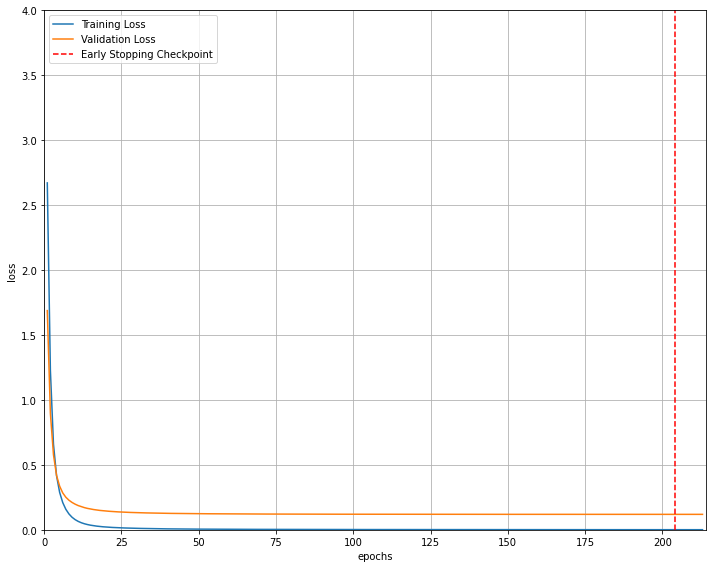

In [59]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(All_end_eopch_training_loss)+1),All_end_eopch_training_loss, label='Training Loss')
plt.plot(range(1,len(All_end_eopch_validation_loss)+1),All_end_eopch_validation_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = All_end_eopch_validation_loss.index(min(All_end_eopch_validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 4) # consistent scale
plt.xlim(0, len(All_end_eopch_training_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Model testing

In [60]:
model = Model().to(device)
model.load_state_dict(torch.load(path))

print("path >> ", path)

path >>  CheckPoints/Resnet_18_3


### Testing loop

In [61]:
fault_images = []
count = 0 

true = []
pred = []
pred_wrong = []
true_wrong = []
image = [] 

In [62]:
losses_testing = [] 
accuracies_testing = []
labels_list = [] 
logits_list = [] 

model.eval()

index = 0

with torch.no_grad():

    for i,batch in tqdm(enumerate(test_loader, 1), total = len(test_loader), position=0, leave=False):
        
        
        inputs, labels, paths = batch

        inputs = inputs.to(device)
    
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 

        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().argmax(dim=1).numpy())

        predicted_labels = logits.cpu().detach().argmax(dim=1).numpy() # list of indices
        logits = logits.to(device)

        J = loss(logits,labels)


        loss_every_batch = J.item()
        losses_testing.append(loss_every_batch)
        

        acc = labels.eq(logits.detach().argmax(dim=1)).float().mean()
        check_it = (logits.detach().argmax(dim=1) != labels).nonzero()

     
        if len(check_it) != 0:
            idicies = check_it.cpu().numpy()
            
            for idx in idicies:
                for ele in idx:
                    fault_images.append([inputs[ele], predicted_labels[ele], labels[ele].item(), paths[ele]])
                    count += 1

        accuracies_testing.append(acc)      
        
        
        
        for i in range(len(predicted_labels)):
            pred.append(predicted_labels[i])
            true.append(labels[i].item())
            if(predicted_labels[i]!=labels[i]):
                pred_wrong.append(predicted_labels[i])
                true_wrong.append(labels[i].item())

        writer.add_scalar("Batch, Testing, loss",loss_every_batch, i)
        writer.add_scalar("Batch, Testing, accuracy",acc, i)

    print()
    print(f'Avg testing loss: {torch.tensor(losses_testing).mean():.5f}', end = ', ')
    print(f'Avg testing accuracy : {torch.tensor(accuracies_testing).float().mean()*100}%')
    print()


Avg testing loss: 0.13246, Avg testing accuracy : 95.76795959472656%



In [63]:
from sklearn import metrics


In [64]:
def performance_matrix(true,pred, type_met):
    precision = metrics.precision_score(true,pred,average=type_met)
    recall = metrics.recall_score(true,pred,average=type_met)
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average=type_met)
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} \n Recall: {}, \n Accuracy: {}: ,\n f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [65]:
performance_matrix(true,pred, 'macro')

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  1  0  0  0  0  0  1  0  1  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 

In [66]:
performance_matrix(true,pred, 'micro')

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  1  0  0  0  0  0  1  0  1  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 

In [67]:
performance_matrix(true,pred, None)

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  1  0  0  0  0  0  1  0  1  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 

In [68]:
performance_matrix(true,pred, "weighted")

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  1  0  0  0  0  0  1  0  1  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 

In [69]:
count

50

In [70]:
len(fault_images)
# , predicted_labels[ele], labels[ele].item()

50

In [71]:
traindataset.dataset.class_to_idx ;
idx2label = {idx:val for val, idx in traindataset.dataset.class_to_idx.items()}

In [72]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [73]:
!ls

 ArSL_Journal_Resnet18_1.ipynb	      CM_Resnet_18_1	    __pycache__
 ArSL_Journal_Resnet18_2.ipynb	      CM_Resnet_18_2	    pytorchtools.py
 ArSL_Journal_Resnet18_SGD_01.ipynb  'Final Data Version'   requirements.txt
 checkpoint.pt			      images		    runs
 CheckPoints			      loss_plot.png


### Print fault images

In [74]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images):
    name_image = f"P_{idx2label[fault_images[i][1]]}_T_{idx2label[fault_images[i][2]]}_{i}.png"
    print(name_image)
    print(fault_images[i][3])
    # plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    # plt.savefig("images/" + name_image, format="png", bbox_inches='tight') # , dpi=400
    # plt.title(name_image)


P_Zain_T_Reh_0.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Reh/Reh_99.jpeg
P_Teh_T_Theh_1.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Theh/Theh_90.jpg
P_Feh_T_Qaf_2.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Qaf/Qaf_188.jpg
P_Jeem_T_Hah_3.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Hah/Hah_69.jpg
P_Dad_T_Sad_4.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Sad/Sad_5.jpg
P_Teh_Marbuta_T_Feh_5.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Feh/Feh_21.jpg
P_Kaf_T_Theh_6.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Theh/Theh_117.jpeg
P_Beh_T_Laa_7.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Jou

<Figure size 1224x1224 with 0 Axes>

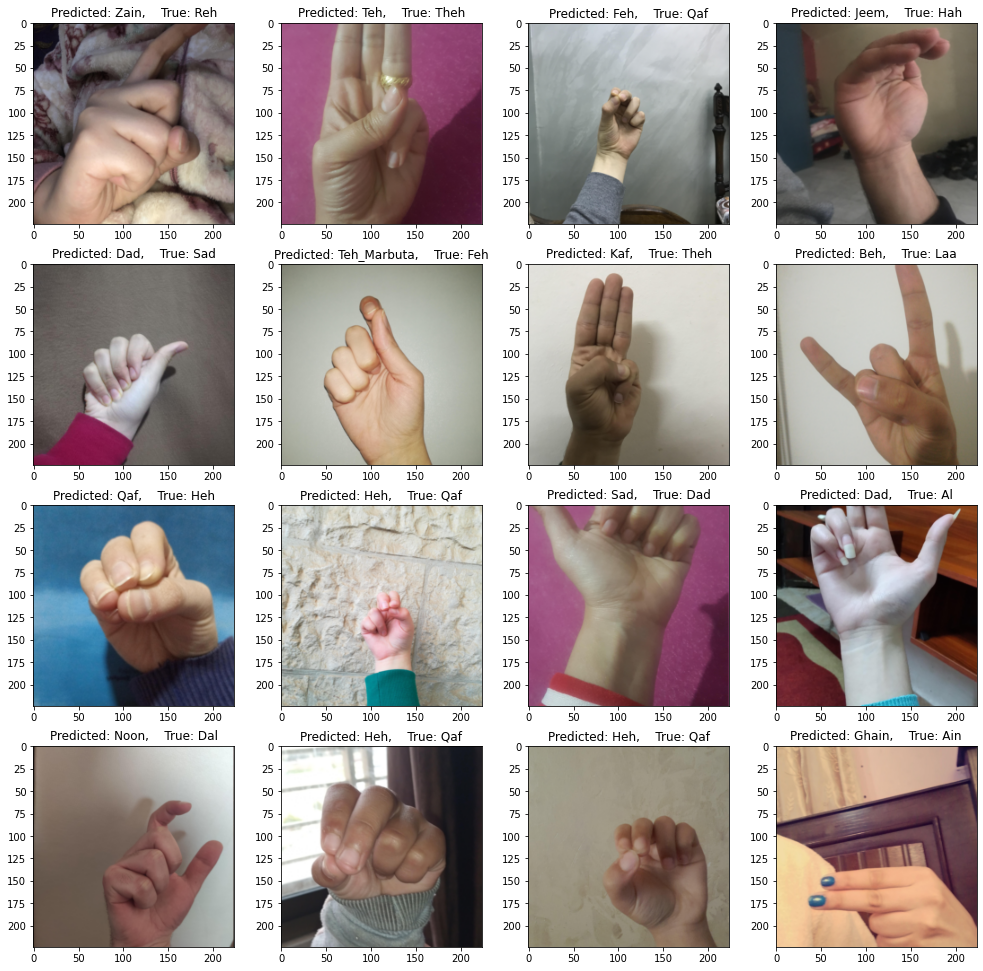

In [75]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[0:16]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


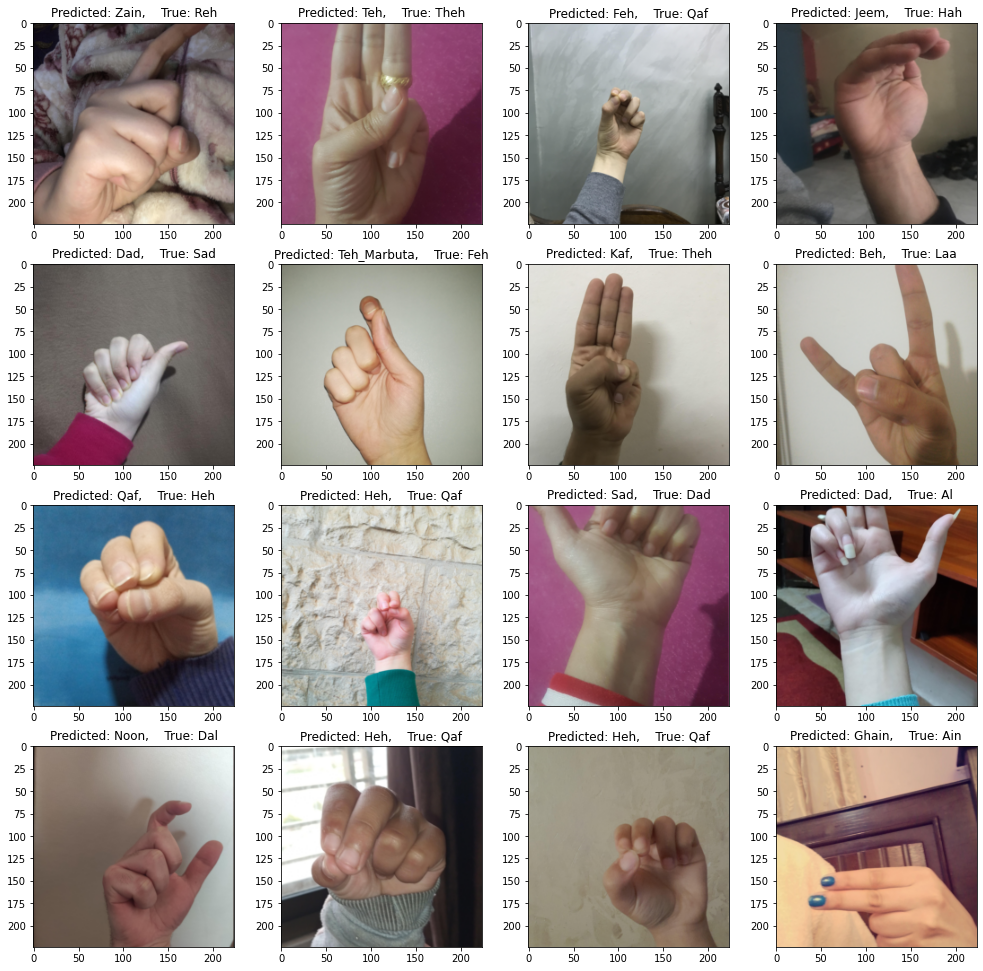

In [76]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[16:32]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


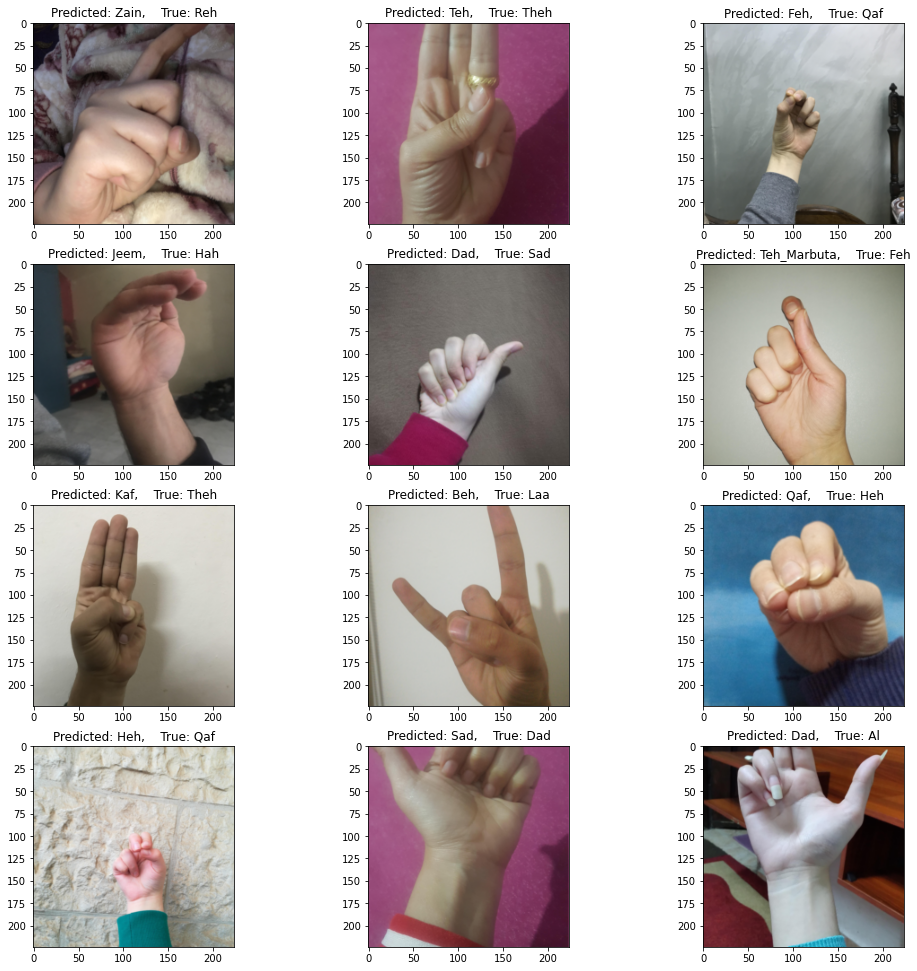

In [77]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[32:44]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


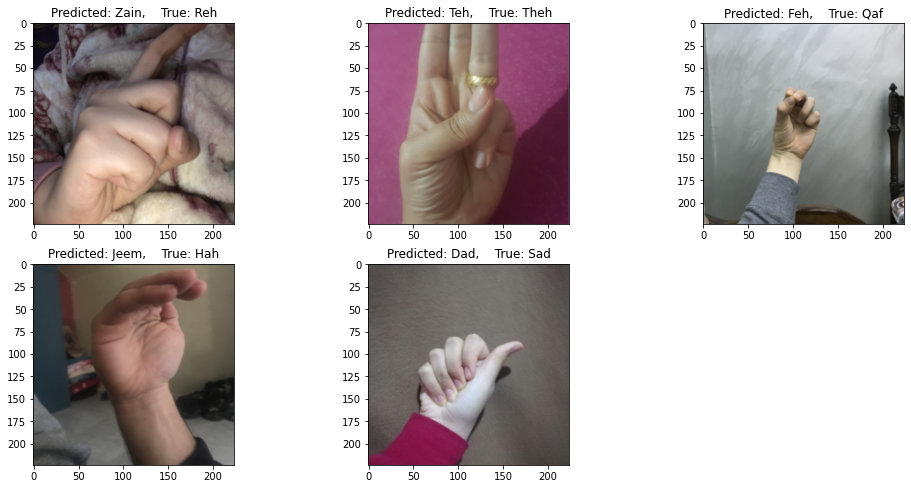

In [78]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[45:54]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


## Plot the confusion matrix 

In [79]:
dic_class_idx = traindataset.dataset.class_to_idx
dic_class_idx

{'Ain': 0,
 'Al': 1,
 'Alef': 2,
 'Beh': 3,
 'Dad': 4,
 'Dal': 5,
 'Feh': 6,
 'Ghain': 7,
 'Hah': 8,
 'Heh': 9,
 'Jeem': 10,
 'Kaf': 11,
 'Khah': 12,
 'Laa': 13,
 'Lam': 14,
 'Meem': 15,
 'Noon': 16,
 'Qaf': 17,
 'Reh': 18,
 'Sad': 19,
 'Seen': 20,
 'Sheen': 21,
 'Tah': 22,
 'Teh': 23,
 'Teh_Marbuta': 24,
 'Thal': 25,
 'Theh': 26,
 'Waw': 27,
 'Yeh': 28,
 'Zah': 29,
 'Zain': 30}

In [80]:
idx_to_class_dic = {v: k for k, v in dic_class_idx.items()}

In [81]:
idx_to_class_dic

{0: 'Ain',
 1: 'Al',
 2: 'Alef',
 3: 'Beh',
 4: 'Dad',
 5: 'Dal',
 6: 'Feh',
 7: 'Ghain',
 8: 'Hah',
 9: 'Heh',
 10: 'Jeem',
 11: 'Kaf',
 12: 'Khah',
 13: 'Laa',
 14: 'Lam',
 15: 'Meem',
 16: 'Noon',
 17: 'Qaf',
 18: 'Reh',
 19: 'Sad',
 20: 'Seen',
 21: 'Sheen',
 22: 'Tah',
 23: 'Teh',
 24: 'Teh_Marbuta',
 25: 'Thal',
 26: 'Theh',
 27: 'Waw',
 28: 'Yeh',
 29: 'Zah',
 30: 'Zain'}

In [82]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [83]:
label_flattened  = flatten(labels_list)
logits_flattened = flatten(logits_list)

In [84]:
cmt = torch.zeros((31,31), dtype=int)
np_arr = cmt.detach().numpy()

In [85]:
for i,_ in enumerate(label_flattened):
   tl = label_flattened[i] 
   pl = logits_flattened[i]
   np_arr[tl,pl] = np_arr[tl,pl] + 1 

In [86]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    cbar = plt.colorbar(fraction=0.0457, pad=0.04)
    cbar.ax.tick_params(labelsize=40)

    
    tick_marks = np.arange(len(classes))

                        #  {'ain'   'al': 'aleff': 'bb': 'dal' 'dha' ,'dhad'  ,'fa', 'gaaf' 'ghain'  'ha'   'haa'  'jeem' 'kaaf' 'khaa'   'la'  'laam'  'meem'  'nun'   'ra'   saad'  'seen'  'sheen'  'ta'  'taa'   'thaa'  'thal'     'toot'      'waw'   'ya': 29          'yaa'   'zay'}
    plt.xticks(tick_marks, [r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah', r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta', r'Thal',r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'],fontsize=80 , rotation=90, fontweight='bold')
    plt.yticks(tick_marks,[r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah',r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta',r'Thal', r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'] ,fontsize=80, fontweight='bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=35, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(r'\bf{True label}', fontsize=40, labelpad=10,fontweight='bold')
    plt.xlabel(r'\bf{Predicted label}', fontsize=40, labelpad=10,fontweight='bold')


Confusion matrix, without normalization
[[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  1  0  0  0  0  0  1  0  1  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0

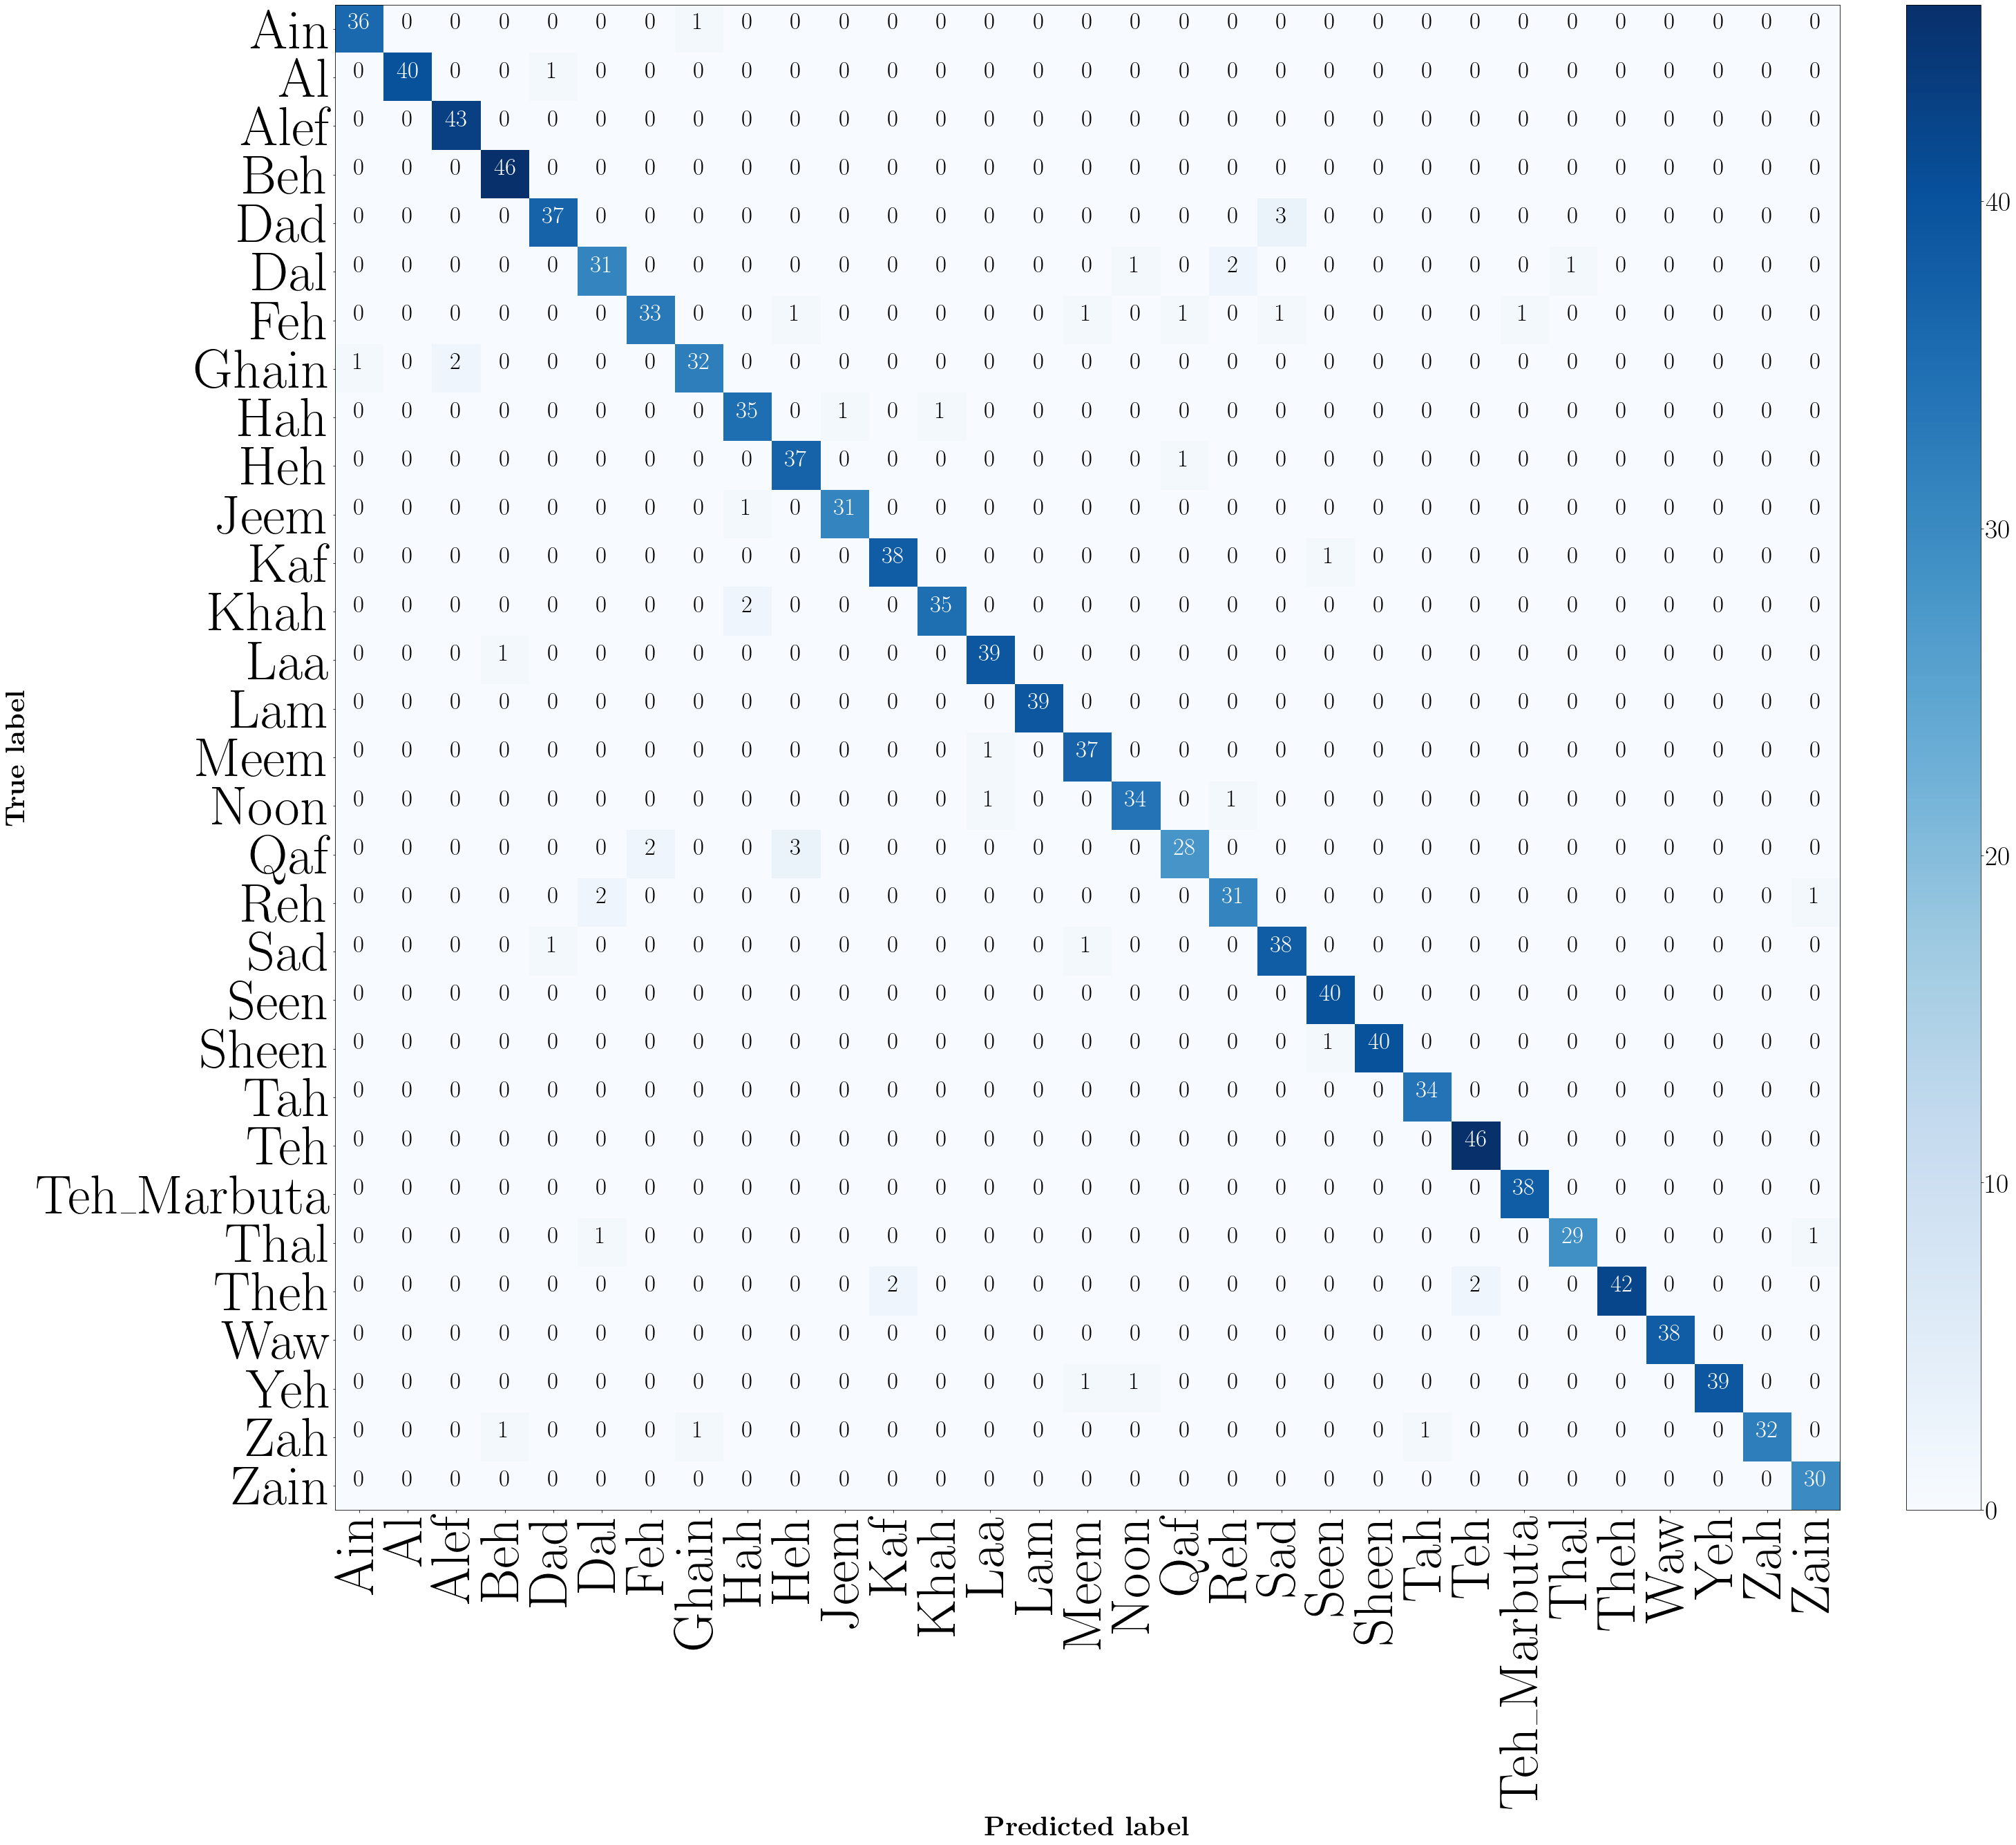

In [87]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl


plt.rcParams.update({ "text.usetex": True})


mpl.rcParams['font.family'] = 'cmu serif'
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(40,40))

plot_confusion_matrix(np_arr,dataset.classes)

print(dataset.classes)

plt.savefig(f"CM_{tensor_baord_variable}", format="pdf", dpi= 400, bbox_inches='tight')
